# Master Thesis Evaluation Pipeline

## Setup & Configuration

In [54]:
import os
import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats

from arch.bootstrap import MCS
from matplotlib.lines import Line2D
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

from IPython.display import display

# Styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 11, 'figure.figsize': (10, 6)})
warnings.simplefilter(action='ignore', category=FutureWarning)

# =============================================================================
# Setup paths (HIER KORRIGIERT: ERST DEFINIEREN, DANN AUFRUFEN)
# =============================================================================

def _locate_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(5):
        if (cur / 'src').exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start.resolve()

# Jetzt kann die Funktion aufgerufen werden:
PROJECT_ROOT = _locate_repo_root(Path.cwd())
STAGEB_DIR = PROJECT_ROOT / "outputs" / "stageB"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")
print(f"Outputs Dir:  {STAGEB_DIR}")

# =============================================================================
# MODEL MAPPING
# =============================================================================

MODEL_MAPPING = {
    "Setup_1": {
        "Extra Trees (S1)": {"path": "extra_trees_without_target", "family": "Trees"},
        "LightGBM (S1)": {"path": "lightgbm_without_target_mac", "family": "Boosting"},
        "Elastic Net (S1)": {"path": "elastic_net_without_target_700", "family": "Linear"},
        "TabPFN (S1)": {"path": "tabpfn_without_target", "family": "Transformers"},
        "SFM (S1)": {"path": "sfm_without_target", "family": "Factor Models"},
        "GPR (S1)": {"path": "gpr_without_target", "family": "Kernel Methods"},
        "SVR (S1)": {"path": "svr_without_target", "family": "Kernel Methods"},
        "Ensemble (S1)": {"path": "ensemble_stacking_without_target", "family": "Ensemble"},
    },
    "Setup_2": {
        "Extra Trees (S2)": {"path": "extra_trees_with_target", "family": "Trees"},
        "LightGBM (S2)": {"path": "lightgbm_with_target_mac", "family": "Boosting"},
        "Elastic Net (S2)": {"path": "elastic_net_with_target_700", "family": "Linear"},
        "TabPFN (S2)": {"path": "tabpfn_with_target", "family": "Transformers"},
        "SFM (S2)": {"path": "sfm_with_target", "family": "Factor Models"},
        "GPR (S2)": {"path": "gpr_with_target", "family": "Kernel Methods"},
        "SVR (S2)": {"path": "svr_with_target", "family": "Kernel Methods"},
        "Ensemble (S2)": {"path": "ensemble_stacking_with_target", "family": "Ensemble"},
    },
    "Setup_3": {
        "Extra Trees (S3)": {"path": "extra_trees_dynamic_fi", "family": "Trees"},
        "LightGBM (S3)": {"path": "lightgbm_dynamic_fi", "family": "Boosting"},
        "Elastic Net (S3)": {"path": "elastic_net_dynamic_fi", "family": "Linear"},
        "TabPFN (S3)": {"path": "tabpfn_dynamic_fi", "family": "Transformers"},
        "SFM (S3)": {"path": "sfm_dynamic_fi", "family": "Factor Models"},
        "GPR (S3)": {"path": "gpr_dynamic_fi", "family": "Kernel Methods"},
        "SVR (S3)": {"path": "svr_dynamic_fi", "family": "Kernel Methods"},
        "Ensemble (S3)": {"path": "ensemble_stacking_dynamic_fi", "family": "Ensemble"},
    },
    "Baselines": {
        "AR(1)": {"path": "baseline_ar1", "family": "Baseline"},
        "RW": {"path": "baseline_rw", "family": "Baseline"},
        "Grand Mean": {"path": "baseline_mean", "family": "Baseline"},
        "Running Mean": {"path": "baseline_ma60", "family": "Baseline"},
    }
}




Project Root: /Users/jonasschernich/Documents/Masterarbeit/Code
Outputs Dir:  /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/stageB


In [55]:

# =============================================================================
# 1. HELPER FUNCTIONS (With Integrated Index Repair)
# =============================================================================
def load_predictions(mapping_dict, stage_dir: Path):
    """
    Loads preds.csv for each model, creates a wide DataFrame,
    and performs HARD deduplication to prevent index errors.
    """
    dfs = []
    y_true = None
    meta = {}

    for name, info in mapping_dict.items():
        path = stage_dir / info["path"] / "monthly" / "preds.csv"
        if not path.exists():
            continue

        try:
            df = pd.read_csv(path, parse_dates=["date_t_plus_1"])
            df = df[df["is_active"] == True].copy()
            # Sortieren für Performance
            df = df.set_index("date_t_plus_1").sort_index()

            # Duplikate pro File entfernen (Soft dedup)
            if df.index.duplicated().any():
                df = df[~df.index.duplicated(keep="first")]

            s_pred = df["y_pred"].rename(name)
            dfs.append(s_pred)

            if y_true is None:
                y = df["y_true"]
                # Auch y_true deduplizieren
                if y.index.duplicated().any():
                    y = y[~y.index.duplicated(keep="first")]
                y_true = y.rename("y_true")

            meta[name] = info
        except Exception as e:
            print(f"Error loading {name}: {e}")

    if not dfs:
        return pd.DataFrame(), {}

    # Zusammenfügen
    df_final = pd.concat([y_true] + dfs, axis=1)

    # --- INTEGRATED REPAIR START ---
    # Wir setzen den Index zurück und gruppieren hart nach Datum.
    # Das entfernt garantiert ALLE versteckten Duplikate/Artefakte.
    if not df_final.index.is_unique:
        print("Note: Deduplicating final dataframe index...")

    df_final = df_final.reset_index()
    # Nimm den ersten Wert pro Datum (ignoriert Duplikate)
    df_final = df_final.groupby("date_t_plus_1").first()
    df_final = df_final.sort_index()
    # --- INTEGRATED REPAIR END ---

    return df_final, meta


# Restliche Helper wie gehabt...
def calculate_dm_test_onesided(e_ref, e_comp, h=12):
    common_idx = e_ref.dropna().index.intersection(e_comp.dropna().index)
    if len(common_idx) < 12: return 0.0, 1.0
    e1, e2 = e_ref.loc[common_idx], e_comp.loc[common_idx]
    d = (e1**2) - (e2**2)
    res = sm.OLS(d, np.ones(len(d))).fit(cov_type="HAC", cov_kwds={"maxlags": h})
    t_stat = float(res.tvalues.iloc[0])
    p_val = float(1.0 - stats.norm.cdf(t_stat))
    return t_stat, p_val

def rmse_on_df(df, pred_col):
    err = df["y_true"] - df[pred_col]
    return float(np.sqrt((err**2).mean()))

def mae_on_df(df, pred_col):
    err = df["y_true"] - df[pred_col]
    return float(err.abs().mean())

def get_common_df(df, cols):
    out = df[cols].dropna()
    return out if not out.empty else None

def get_mcs_pvalues(losses_df, size=0.10, block_size=12):
    if losses_df is None or losses_df.shape[1] < 2 or len(losses_df) < 15: return {}
    mcs = MCS(losses_df, size=size, method="R", block_size=block_size)
    mcs.compute()
    return mcs.pvalues.iloc[:, 0] if isinstance(mcs.pvalues, pd.DataFrame) else mcs.pvalues

def best_model_on_common(df_common, model_cols):
    rmse_map = {m: rmse_on_df(df_common, m) for m in model_cols}
    return min(rmse_map, key=rmse_map.get), rmse_map

def clean_model_name(model_key):
    mapping = {"Extra Tree": "Extra Trees", "ET": "Extra Trees", "RF": "Random Forest",
               "LGBM": "LightGBM", "ElNet": "Elastic Net", "Elastic": "Elastic Net"}
    for k, v in mapping.items():
        if k in model_key: return v
    return model_key

# =============================================================================
# 2. LOAD DATA (Reloading with new logic)
# =============================================================================
all_mappings = {}
for group in MODEL_MAPPING.values():
    all_mappings.update(group)

df_full, meta_full = load_predictions(all_mappings, STAGEB_DIR)

print("-" * 30)
print(f"Final Data Shape: {df_full.shape}")
print(f"Index Unique?     {df_full.index.is_unique}")
print("-" * 30)

# Kleiner Test, ob Mathe jetzt funktioniert
try:
    test = df_full["y_true"] - df_full.iloc[:, 0]
    print("Check passed: Subtraction works without error.")
except Exception as e:
    print(f"CHECK FAILED: {e}")

baseline_keys = [k for k in MODEL_MAPPING["Baselines"].keys() if k in df_full.columns]

------------------------------
Final Data Shape: (166, 29)
Index Unique?     True
------------------------------
Check passed: Subtraction works without error.


In [24]:
# =============================================================================
# 1) Table R1 per setup (STRICT common set + one-sided DM vs best + MCS)
# =============================================================================

def evaluate_setup_strict(setup_name: str, setup_dict: dict, df_data: pd.DataFrame):
    keys = [k for k in setup_dict.keys() if k in df_data.columns]
    if not keys:
        print(f"Skipping {setup_name} (no columns).")
        return None

    df_common = get_common_df(df_data, keys + ["y_true"])
    if df_common is None or len(df_common) < 15:
        print(f"Skipping {setup_name} (not enough common data).")
        return None

    # RMSE/MAE on strict common set
    res = []
    for k in keys:
        res.append({"Model": k, "RMSE": rmse_on_df(df_common, k), "MAE": mae_on_df(df_common, k)})

    df_res = pd.DataFrame(res).set_index("Model")
    best_model, _ = best_model_on_common(df_common, keys)

    # MCS on common set
    losses = (df_common["y_true"].values[:, None] - df_common[keys].values) ** 2
    df_losses = pd.DataFrame(losses, columns=keys, index=df_common.index)
    mcs_pvals = get_mcs_pvalues(df_losses, size=0.10, block_size=12)

    final_table = []
    e_best = df_common["y_true"] - df_common[best_model]

    for k in keys:
        if k == best_model:
            dm_sig = "(Best)"
        else:
            e_curr = df_common["y_true"] - df_common[k]
            # Test: Is best significantly better than k?
            # H1: e_curr^2 - e_best^2 > 0  (curr worse)
            t, p = calculate_dm_test_onesided(e_curr, e_best, h=12)
            dm_sig = ""
            if (p < 0.05) and (t > 0):
                dm_sig = "***"
            elif (p < 0.10) and (t > 0):
                dm_sig = "*"

        in_mcs = "no"
        if isinstance(mcs_pvals, (pd.Series, dict)):
            val = float(mcs_pvals.get(k, 0.0)) if isinstance(mcs_pvals, dict) else float(mcs_pvals.get(k, 0.0))
            if val > 0.10:
                in_mcs = "YES"

        final_table.append({
            "Model": k,
            "RMSE (Common)": df_res.loc[k, "RMSE"],
            "MAE (Common)": df_res.loc[k, "MAE"],
            "MCS": in_mcs
        })

    print(f"\n>>> TABLE R1 (Strict Common): {setup_name} <<<")
    print(f"Evaluated on N={len(df_common)} common months.")
    display(pd.DataFrame(final_table).style.highlight_min(subset=["RMSE (Common)", "MAE (Common)"], color="lightgreen"))
    return df_common, best_model


evaluate_setup_strict("Setup I (ifo Only)", MODEL_MAPPING["Setup_1"], df_full)
evaluate_setup_strict("Setup II (ifo + Targets)", MODEL_MAPPING["Setup_2"], df_full)
evaluate_setup_strict("Setup III (Dynamic FE)", MODEL_MAPPING["Setup_3"], df_full)




>>> TABLE R1 (Strict Common): Setup I (ifo Only) <<<
Evaluated on N=166 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,Extra Trees (S1),2.309302,1.396025,YES
1,LightGBM (S1),2.315589,1.441090,YES
2,Elastic Net (S1),2.312581,1.485336,YES
3,TabPFN (S1),2.197633,1.370506,YES
4,SFM (S1),2.409276,1.543917,YES
5,GPR (S1),2.450065,1.482823,YES
6,SVR (S1),2.307209,1.383108,YES
7,Ensemble (S1),2.236282,1.422838,YES



>>> TABLE R1 (Strict Common): Setup II (ifo + Targets) <<<
Evaluated on N=166 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,Extra Trees (S2),2.127005,0.999824,YES
1,LightGBM (S2),1.697285,0.848321,YES
2,Elastic Net (S2),2.048163,1.233680,no
3,TabPFN (S2),2.049669,1.255102,no
4,SFM (S2),2.317117,1.651083,no
5,GPR (S2),2.522283,1.542992,no
6,SVR (S2),2.461226,1.609330,no
7,Ensemble (S2),1.678841,0.821920,YES



>>> TABLE R1 (Strict Common): Setup III (Dynamic FE) <<<
Evaluated on N=166 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,Extra Trees (S3),2.305851,1.375678,YES
1,LightGBM (S3),2.370649,1.387490,YES
2,Elastic Net (S3),2.314105,1.365950,YES
3,TabPFN (S3),2.330182,1.438263,YES
4,SFM (S3),2.341151,1.443693,YES
5,GPR (S3),2.350832,1.377002,YES
6,SVR (S3),2.342188,1.374026,YES
7,Ensemble (S3),2.314105,1.365950,YES


(               Extra Trees (S3)  LightGBM (S3)  Elastic Net (S3)  TabPFN (S3)  \
 date_t_plus_1                                                                   
 2011-03-01             0.430915      -0.059244          0.226811     0.417074   
 2011-04-01             0.332354      -0.054402          0.201930     0.351902   
 2011-05-01             0.320623      -0.084256          0.251719     0.559716   
 2011-06-01             0.217585      -0.040662          0.085012     0.321768   
 2011-07-01             0.089889      -0.021055          0.095224     0.183058   
 ...                         ...            ...               ...          ...   
 2024-08-01            -0.207166      -0.198469         -0.087389    -0.046812   
 2024-09-01            -0.322750      -0.078056         -0.059416    -0.113020   
 2024-10-01            -0.223386       0.223764         -0.070539     0.015786   
 2024-11-01            -0.209792       0.164937         -0.071345     0.032405   
 2024-12-01     

## Model Confidence Sets

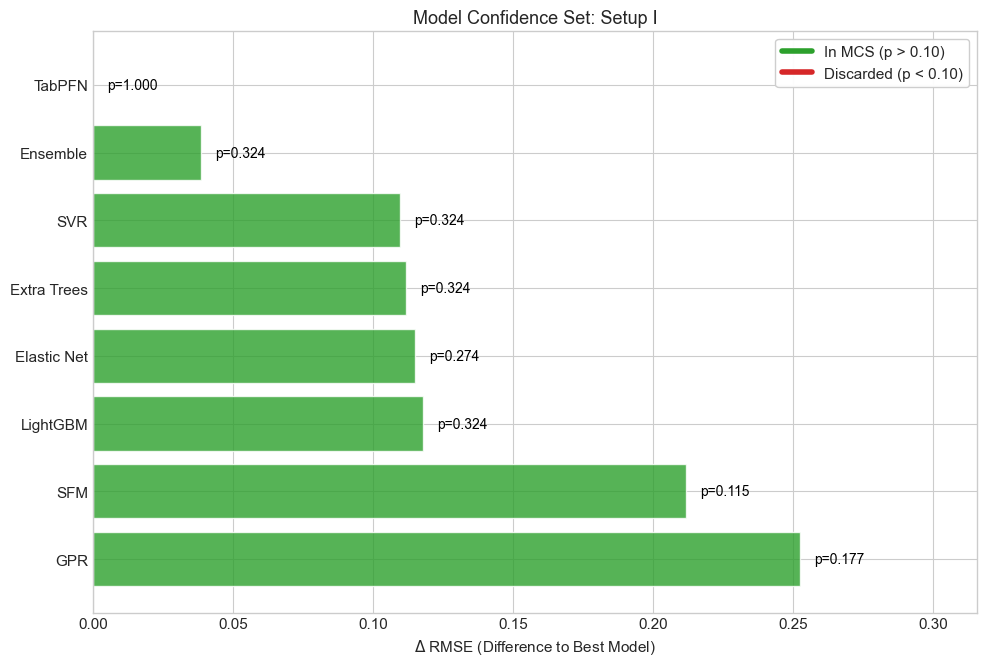

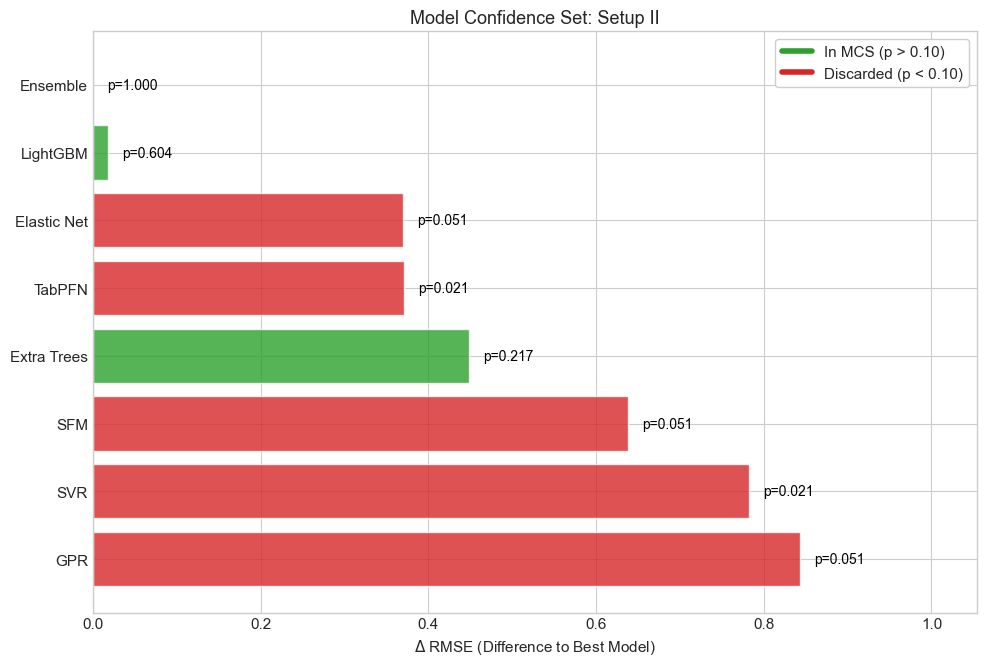

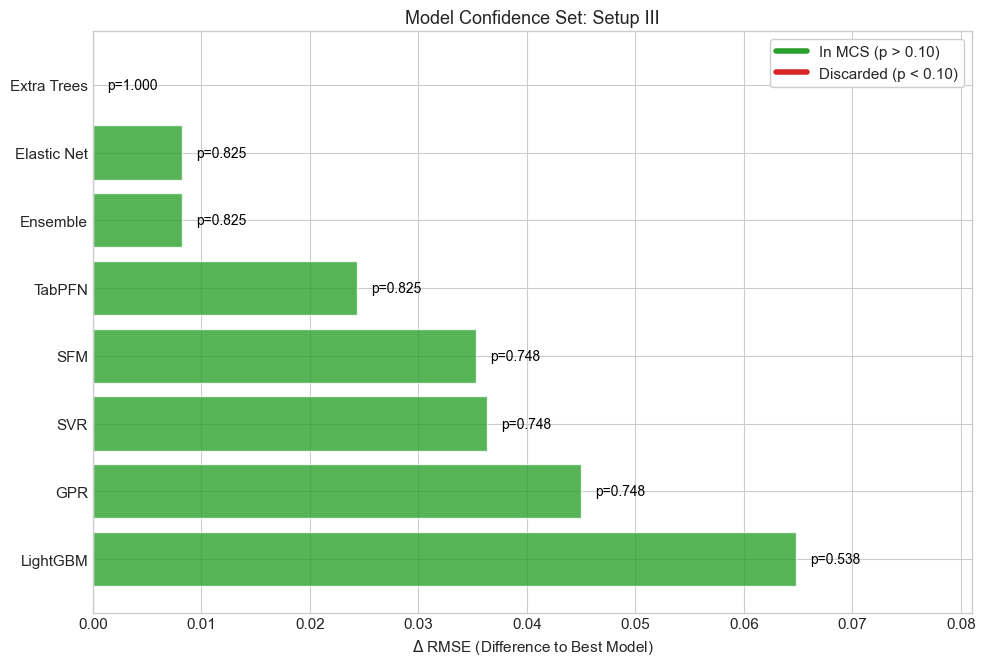

In [34]:
# =============================================================================
# MCS plots per setup (STRICT common set)
# (CLEANED LABELS + LEGEND UPPER RIGHT)
# =============================================================================

def plot_mcs_bars_strict(setup_name: str, setup_keys, df_data: pd.DataFrame):
    keys = [k for k in setup_keys if k in df_data.columns]
    if len(keys) < 2:
        print(f"Skipping MCS for {setup_name} (not enough models).")
        return

    df_common = get_common_df(df_data, keys + ["y_true"])
    if df_common is None or len(df_common) < 15:
        print(f"Skipping MCS for {setup_name} (not enough common data).")
        return

    losses = (df_common["y_true"].values[:, None] - df_common[keys].values) ** 2
    df_losses = pd.DataFrame(losses, columns=keys, index=df_common.index)

    mcs_pvals = get_mcs_pvalues(df_losses, size=0.10, block_size=12)
    if not isinstance(mcs_pvals, (pd.Series, dict)):
        print("MCS p-values unavailable.")
        return

    rmse_data = []
    for k in keys:
        # Label bereinigen: "ET (S1)" -> "ET"
        clean_label = k.split(" (")[0]

        rmse_val = rmse_on_df(df_common, k)
        p_val = float(mcs_pvals.get(k, 0.0)) if isinstance(mcs_pvals, dict) else float(mcs_pvals.get(k, 0.0))
        rmse_data.append({"Model": clean_label, "RMSE": rmse_val, "p_val": p_val})

    df_plot = pd.DataFrame(rmse_data)
    min_rmse = df_plot["RMSE"].min()
    df_plot["Delta_RMSE"] = df_plot["RMSE"] - min_rmse

    # Sortieren: Schlechtestes Modell (großes Delta) zuerst im DF -> unten im Plot
    # Bestes Modell (Delta 0) zuletzt im DF -> oben im Plot
    df_plot = df_plot.sort_values("Delta_RMSE", ascending=False)

    plt.figure(figsize=(10, len(keys) * 0.6 + 2))

    colors = ["#2ca02c" if row["p_val"] > 0.10 else "#d62728" for _, row in df_plot.iterrows()]
    bars = plt.barh(df_plot["Model"], df_plot["Delta_RMSE"], color=colors, alpha=0.8)

    max_x = df_plot["Delta_RMSE"].max()
    offset = max_x * 0.02 if max_x > 0 else 0.01

    for bar, p_val in zip(bars, df_plot["p_val"]):
        plt.text(bar.get_width() + offset, bar.get_y() + bar.get_height() / 2, f"p={p_val:.3f}",
                 va='center', fontsize=10, color="black")

    plt.title(f"Model Confidence Set: {setup_name}", fontsize=13)
    plt.xlabel(r"$\Delta$ RMSE (Difference to Best Model)")

    # --- LEGENDE OBEN RECHTS ---
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#2ca02c', lw=4, label='In MCS (p > 0.10)'),
        Line2D([0], [0], color='#d62728', lw=4, label='Discarded (p < 0.10)')
    ]
    plt.legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.95)

    if max_x > 0:
        plt.xlim(0, max_x * 1.25)
    plt.tight_layout()

    #--- OPTIONAL: GRAFIK SPEICHERN (standardmäßig auskommentiert) ---
    # import os
    # os.makedirs("grafiken", exist_ok=True)
    # safe_name = setup_name.replace(" ", "_").replace("/", "-")
    # plt.savefig(f"grafiken/MCS_{safe_name}.png", dpi=300, bbox_inches="tight")

    plt.show()

# Ausführen
plot_mcs_bars_strict("Setup I", MODEL_MAPPING["Setup_1"].keys(), df_full)
plot_mcs_bars_strict("Setup II", MODEL_MAPPING["Setup_2"].keys(), df_full)
plot_mcs_bars_strict("Setup III", MODEL_MAPPING["Setup_3"].keys(), df_full)



Tabelle für Setup II (rel. RMSE + p-Werte):
      Model RMSE_Ratio   p_value  Status
   LightGBM     0.7330 0.0004145  better
   Ensemble     0.7507 0.0003414  better
Elastic Net     0.8857   0.02031  better
Extra Trees     0.9211    0.2734 neutral
     TabPFN     0.9327    0.2444 neutral
        SFM     0.9617    0.7796 neutral
        GPR     1.0295    0.7312 neutral
        SVR     1.0668   0.00482   worse


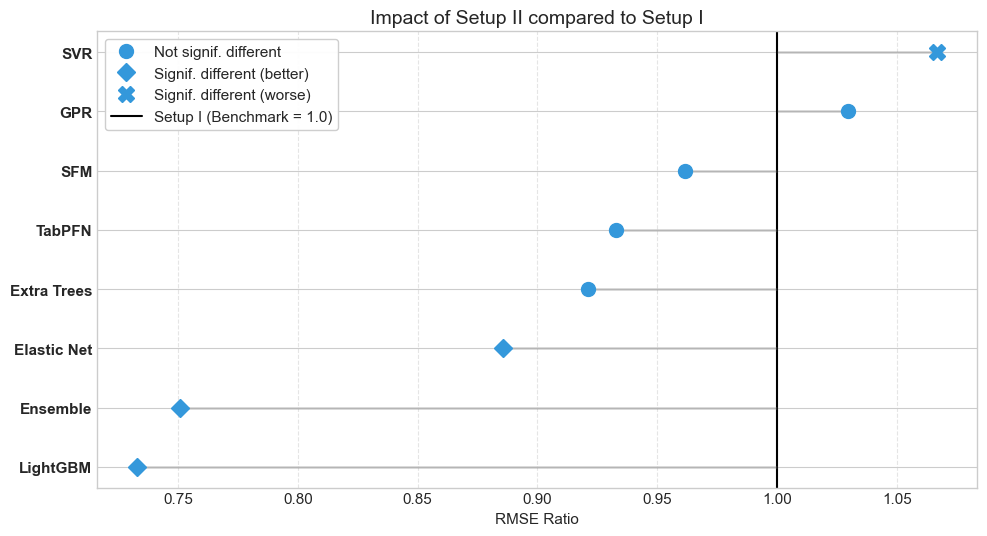


Tabelle für Setup III (rel. RMSE + p-Werte):
      Model RMSE_Ratio  p_value  Status
        GPR     0.9595 0.004358  better
        SFM     0.9717   0.3184 neutral
Extra Trees     0.9985   0.8814 neutral
Elastic Net     1.0007   0.9909 neutral
        SVR     1.0152   0.4679 neutral
   LightGBM     1.0238   0.5547 neutral
   Ensemble     1.0348   0.4726 neutral
     TabPFN     1.0603  0.06999 neutral


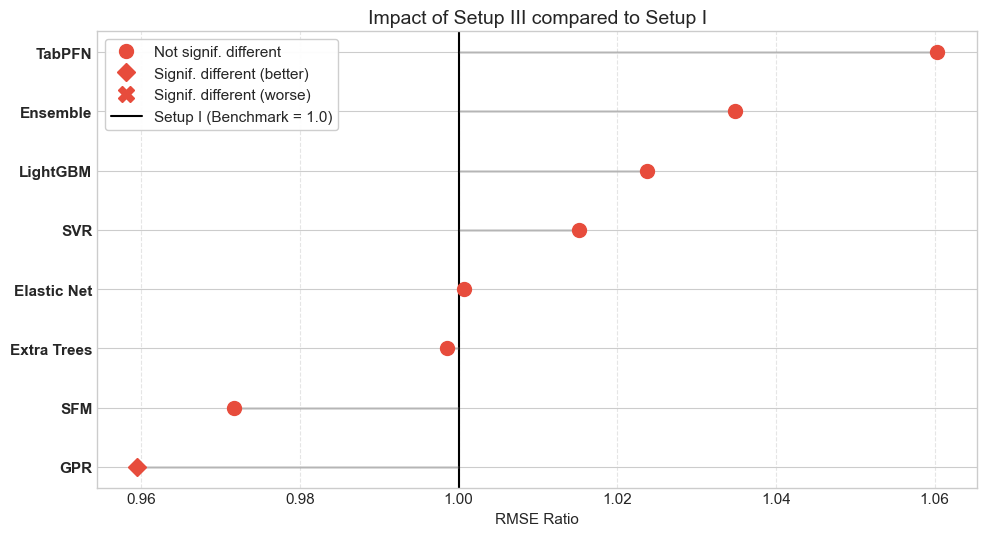

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# =============================================================================
# Helper: Zweiseitiger DM-Test
# =============================================================================
def calculate_dm_test_twosided(series_bench, series_curr, h=1):
    e_bench = series_bench.values
    e_curr = series_curr.values
    d = (e_bench**2) - (e_curr**2)
    T = len(d)
    lags = int(T**(0.25))
    try:
        res = sm.OLS(d, np.ones(T)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        t_stat = res.tvalues[0]
        p_val = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=T-1))
    except:
        t_stat, p_val = 0.0, 1.0
    return t_stat, p_val

# =============================================================================
# Datenaufbereitung
# =============================================================================
for setup_group in MODEL_MAPPING.values():
    for key, info in setup_group.items():
        base_name = key.split(" (")[0]
        info["label"] = base_name

color_s2 = "#3498db"
color_s3 = "#e74c3c"
setup1_models = MODEL_MAPPING["Setup_1"]
plot_data = []

# =============================================================================
# Loop: RMSE Ratio berechnen (Model / Benchmark)
# =============================================================================
for k_s1, info_s1 in setup1_models.items():
    if k_s1 not in df_full.columns:
        continue
    model_label = info_s1["label"]

    for setup_key, setup_label_txt, col in [("Setup_2", "Setup II", color_s2),
                                            ("Setup_3", "Setup III", color_s3)]:

        mod_curr = next((k for k, v in MODEL_MAPPING[setup_key].items()
                         if v.get("label") == model_label and k in df_full.columns), None)
        if not mod_curr:
            continue

        tmp = get_common_df(df_full, [k_s1, mod_curr, "y_true"])
        if tmp is None or len(tmp) < 15:
            continue

        val_s1 = rmse_on_df(tmp, k_s1)
        val_curr = rmse_on_df(tmp, mod_curr)

        ratio = val_curr / val_s1

        err_s1 = tmp["y_true"] - tmp[k_s1]
        err_c  = tmp["y_true"] - tmp[mod_curr]
        t_stat, p_val = calculate_dm_test_twosided(err_s1, err_c)

        is_sig = p_val < 0.05

        if not is_sig:
            marker = 'o'
            msize = 10
            status = "neutral"
        else:
            if ratio < 1.0:
                marker = 'D'
                msize = 9
                status = "better"
            else:
                marker = 'X'
                msize = 11
                status = "worse"

        plot_data.append({
            "Model": model_label,
            "Setup": setup_label_txt,
            "RMSE_Ratio": ratio,   # <-- NEU/UMBENANNT (statt Diff)
            "p_value": p_val,      # <-- NEU
            "Color": col,
            "Marker": marker,
            "MSize": msize,
            "Status": status
        })

df_plot_all = pd.DataFrame(plot_data)

# =============================================================================
# Plotting + Tabellen-Ausgabe
# =============================================================================
def create_pairwise_plot(df, setup_filter, color, title_suffix):
    subset = df[df["Setup"] == setup_filter].copy()
    if subset.empty:
        print(f"Keine Daten für {setup_filter}")
        return

    subset = subset.sort_values("RMSE_Ratio", ascending=True)
    sorted_models = subset["Model"].tolist()
    y_pos = {mod: i for i, mod in enumerate(sorted_models)}

    # --- NEU: Tabelle je Grafik (rel. RMSE + p-Werte) ---
    table_df = subset[["Model", "RMSE_Ratio", "p_value", "Status"]].copy()
    table_df["RMSE_Ratio"] = table_df["RMSE_Ratio"].map(lambda x: f"{x:.4f}")
    table_df["p_value"]    = table_df["p_value"].map(lambda x: f"{x:.4g}")

    print(f"\nTabelle für {setup_filter} (rel. RMSE + p-Werte):")
    print(table_df.to_string(index=False))

    import os
    os.makedirs("grafiken", exist_ok=True)
    safe_setup = setup_filter.replace(" ", "_").replace("/", "-")
    table_df.to_csv(f"grafiken/Table_{safe_setup}.csv", index=False)

    # --- Plot ---
    fig = plt.figure(figsize=(10, len(sorted_models) * 0.5 + 1.5))

    plt.axvline(1.0, color='black', linewidth=1.5, zorder=1)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)

    for _, row in subset.iterrows():
        y = y_pos[row["Model"]]
        plt.hlines(y, min(1.0, row["RMSE_Ratio"]), max(1.0, row["RMSE_Ratio"]),
                   color='gray', alpha=0.3, linewidth=2, zorder=1)

        plt.plot(row["RMSE_Ratio"], y,
                 marker=row["Marker"],
                 markersize=row["MSize"],
                 markerfacecolor=row["Color"],
                 markeredgecolor=row["Color"],
                 linewidth=0, zorder=3)

    plt.yticks(range(len(sorted_models)), sorted_models, fontsize=11, fontweight='bold')
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    plt.xlabel("RMSE Ratio", fontsize=11)
    plt.title(f"Impact of {title_suffix} compared to Setup I", fontsize=14)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color, markeredgecolor=color,
               label='Not signif. different', markersize=10),
        Line2D([0], [0], marker='D', color='w',
               markerfacecolor=color, markeredgecolor=color,
               label='Signif. different (better)', markersize=9),
        Line2D([0], [0], marker='X', color='w',
               markerfacecolor=color, markeredgecolor=color,
               label='Signif. different (worse)', markersize=11),
        Line2D([0], [0], color='black', linewidth=1.5,
               label='Setup I (Benchmark = 1.0)')
    ]

    plt.legend(handles=legend_elements, loc='upper left', ncol=1, frameon=True, framealpha=0.95)
    plt.tight_layout()

    # --- Speichern (vor show) ---
    fig.savefig(f"grafiken/Pairwise_{safe_setup}.png", dpi=300, bbox_inches="tight")

    plt.show()
    # optional:
    # plt.close(fig)

# =============================================================================
# Ausführen
# =============================================================================
if not df_plot_all.empty:
    create_pairwise_plot(df_plot_all, "Setup II", color_s2, "Setup II")
    create_pairwise_plot(df_plot_all, "Setup III", color_s3, "Setup III")
else:
    print("Keine Plot-Daten vorhanden.")



Referenz-Baseline für Plot & Tabelle: Running Mean

>>> TABLE: Performance vs. Running Mean <<<


,Setup,Model,Rel_RMSE,p_val
3,Setup I,TabPFN,0.9245,0.2960
7,Setup I,Ensemble,0.9407,0.3635
6,Setup I,SVR,0.9706,0.2969
0,Setup I,Extra Trees,0.9714,0.4236
2,Setup I,Elastic Net,0.9728,0.7086
1,Setup I,LightGBM,0.9741,0.5438
4,Setup I,SFM,1.0135,0.8345
5,Setup I,GPR,1.0307,0.0028
15,Setup II,Ensemble,0.7062,0.0203
9,Setup II,LightGBM,0.7140,0.0141


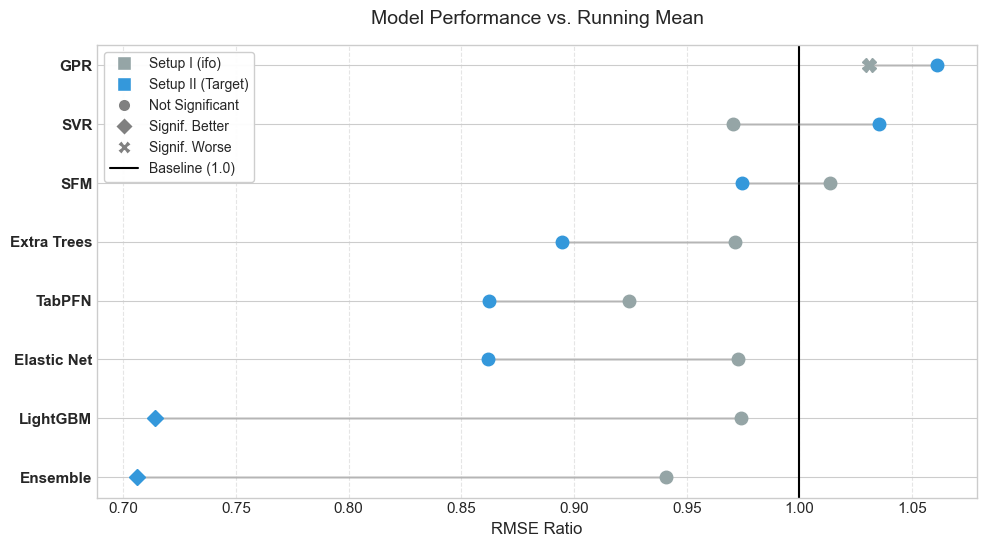

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import statsmodels.api as sm
from scipy import stats
from IPython.display import display

# =============================================================================
# Figure R1: Combined Dot Plot (Setup I vs Setup II) vs RUNNING MEAN BASELINE
# + Table with Relative RMSE and p-values
# =============================================================================

def calculate_dm_test_twosided_local(series_bench, series_curr):
    e_bench = series_bench.values
    e_curr = series_curr.values
    d = (e_bench**2) - (e_curr**2)
    T = len(d)
    lags = int(T**(0.25))
    try:
        res = sm.OLS(d, np.ones(T)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        t_stat = res.tvalues[0]
        p_val = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=T-1))
    except:
        t_stat, p_val = 0.0, 1.0
    return t_stat, p_val

def rel_rmse_vs_baseline_same_sample(df: pd.DataFrame, model_col: str, baseline_col: str):
    """
    Berechnet relativen RMSE und DM-Test. Gibt nun auch p_val zurück.
    """
    tmp = get_common_df(df, [model_col, baseline_col, "y_true"])
    if tmp is None or len(tmp) < 15:
        # Return p_val as nan if check fails
        return np.nan, False, False, False, np.nan

    rmse_model = rmse_on_df(tmp, model_col)
    rmse_base = rmse_on_df(tmp, baseline_col)
    rel = rmse_model / rmse_base if rmse_base > 0 else np.nan

    e_bl = tmp["y_true"] - tmp[baseline_col]
    e_mod = tmp["y_true"] - tmp[model_col]
    t_stat, p_val = calculate_dm_test_twosided_local(e_bl, e_mod)

    is_sig = p_val < 0.05
    is_better = is_sig and (t_stat > 0)
    is_worse = is_sig and (t_stat < 0)

    return rel, is_sig, is_better, is_worse, p_val


if baseline_keys:
    # --- Explizit "Running Mean" wählen ---
    target_bl_name = "Running Mean"

    if target_bl_name in baseline_keys:
        ref_bl = target_bl_name
    else:
        # Fallback Suche
        ref_bl = next((k for k in baseline_keys if "Running Mean" in k or "MA60" in k), None)

    if ref_bl is None:
        print(f"Warnung: '{target_bl_name}' nicht in Baseline Keys gefunden. Nutze Best Baseline als Fallback.")
        ref_bl = best_baseline_name(df_full, baseline_keys)

    print(f"Referenz-Baseline für Plot & Tabelle: {ref_bl}")

    if ref_bl is None:
        print("No valid baseline found.")
    else:
        data_rows = []
        setup_defs = [("Setup_1", "Setup I"), ("Setup_2", "Setup II")]

        for setup_key, setup_label in setup_defs:
            for model_key, info in MODEL_MAPPING[setup_key].items():
                if model_key not in df_full.columns:
                    continue

                clean_name = info["label"] if "label" in info else model_key.split(" (")[0]

                # Aufruf mit p_val Rückgabe
                rel, is_sig, is_better, is_worse, p_val = rel_rmse_vs_baseline_same_sample(df_full, model_key, ref_bl)

                if not np.isfinite(rel):
                    continue

                if not is_sig:
                    marker = 'o'
                elif is_better:
                    marker = 'D'
                else:
                    marker = 'X'

                data_rows.append({
                    "Model": clean_name,
                    "Setup": setup_label,
                    "Rel_RMSE": rel,
                    "Marker": marker,
                    "IsSig": is_sig,
                    "p_val": p_val  # p-Wert speichern
                })

        df_plot = pd.DataFrame(data_rows)

        # --- TABELLE AUSGEBEN ---
        if not df_plot.empty:
            print(f"\n>>> TABLE: Performance vs. {ref_bl} <<<")
            table_df = df_plot[["Setup", "Model", "Rel_RMSE", "p_val"]].copy()
            table_df = table_df.sort_values(["Setup", "Rel_RMSE"])

            # Formatierung
            display(table_df.style.format({
                "Rel_RMSE": "{:.4f}",
                "p_val": "{:.4f}"
            }).background_gradient(subset=["Rel_RMSE"], cmap="RdYlGn_r", vmin=0.8, vmax=1.2))
        else:
            print("Keine Daten für Tabelle.")


        # --- PLOT START ---
        if df_plot.empty:
            print("No data for dot plot.")
        else:
            s2_subset = df_plot[df_plot["Setup"] == "Setup II"].copy()
            if s2_subset.empty:
                sort_order = df_plot.sort_values("Rel_RMSE", ascending=True)["Model"].unique()
            else:
                s2_subset = s2_subset.sort_values("Rel_RMSE", ascending=True)
                sort_order = s2_subset["Model"].unique()

            model_map_y = {m: i for i, m in enumerate(sort_order)}

            fig, ax = plt.subplots(figsize=(10, len(sort_order) * 0.45 + 2.0), dpi=100)

            # --- ÄNDERUNG 1: Linie durchgezogen und Text entfernt ---
            ax.axvline(1.0, color='black', linewidth=1.5, zorder=1)
            # ax.text(...) wurde hier entfernt

            ax.grid(True, axis='x', linestyle='--', alpha=0.5)

            for m in sort_order:
                sub = df_plot[df_plot["Model"] == m]
                if not sub.empty:
                    y_pos = model_map_y[m]
                    min_r, max_r = sub["Rel_RMSE"].min(), sub["Rel_RMSE"].max()
                    ax.hlines(y_pos, min_r, max_r, color='gray', alpha=0.3, linewidth=2, zorder=2)

            colors = {"Setup I": "#95a5a6", "Setup II": "#3498db"}

            for setup in ["Setup I", "Setup II"]:
                sub = df_plot[df_plot["Setup"] == setup]
                for _, row in sub.iterrows():
                    y = model_map_y.get(row["Model"], None)
                    if y is None:
                        continue

                    msize = 8 if row["IsSig"] else 9
                    if row["Marker"] == 'X':
                        msize = 10

                    ax.plot(row["Rel_RMSE"], y,
                            marker=row["Marker"], markersize=msize,
                            markerfacecolor=colors[setup], markeredgecolor=colors[setup],
                            linestyle='', zorder=3, label='_nolegend_')

            ax.set_yticks(np.arange(len(sort_order)))
            ax.set_yticklabels(sort_order, fontsize=11, fontweight='bold')
            ax.set_xlabel(f"RMSE Ratio", fontsize=12)
            ax.set_title(f"Model Performance vs. {ref_bl}", fontsize=14, pad=15)
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

            legend_elements = [
                Line2D([0], [0], marker='s', color='w', markerfacecolor=colors["Setup I"], label='Setup I (ifo)', markersize=10),
                Line2D([0], [0], marker='s', color='w', markerfacecolor=colors["Setup II"], label='Setup II (Target)', markersize=10),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', label='Not Significant', markersize=9),
                Line2D([0], [0], marker='D', color='w', markerfacecolor='gray', label='Signif. Better', markersize=9),
                Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', label='Signif. Worse', markersize=10),
                # --- ÄNDERUNG 2: Linie in Legende durchgezogen ---
                Line2D([0], [0], color='black', linewidth=1.5, label='Baseline (1.0)'),
            ]

            ax.legend(handles=legend_elements, loc='upper left', ncol=1,
                      frameon=True, framealpha=0.95, fontsize=10)

            fig.tight_layout()

            # Speichern
            import os
            os.makedirs("grafiken", exist_ok=True)
            safe_bl = str(ref_bl).replace(" ", "_").replace("/", "-")
            fig.savefig(f"grafiken/Figure_R1_vs_{safe_bl}.png", dpi=300, bbox_inches="tight")

            plt.show()

else:
    print("Keine Baseline Keys definiert.")

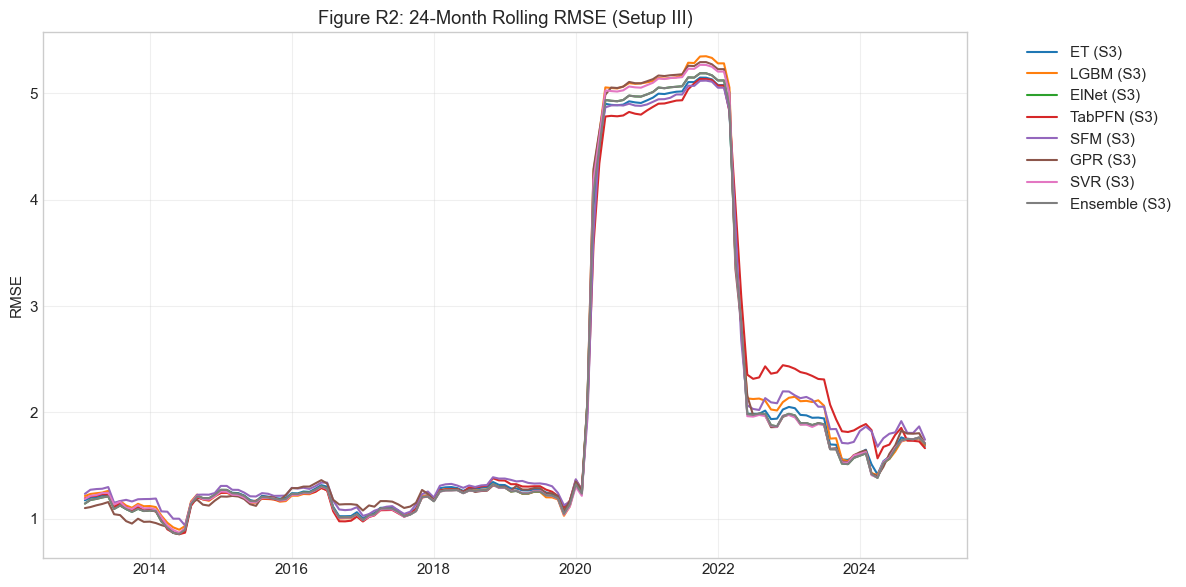


>>> TABLE R3: Detailed Comparison vs All Baselines (same-sample) <<<
Significance levels (Model beats Baseline): * p<0.10, ** p<0.05, *** p<0.01 (one-sided)


,Model,Type,AR(1),Hist.Mean,RW,RMSE (min common vs BL)
5,Ensemble (S2),Model (S2),0.6828 **,0.7108 **,0.7124 **,1.6788
10,LGBM (S2),Model (S2),0.6903 **,0.7186 **,0.7202 **,1.6973
3,ElNet (S2),Model (S2),0.8331,0.8672,0.8691,2.0482
17,TabPFN (S2),Model (S2),0.8337,0.8678,0.8698,2.0497
1,ET (S2),Model (S2),0.8651 **,0.9006 **,0.9026 **,2.1270
2,ET (S3),Model (S3),0.9379,0.9763,0.9785,2.3059
4,ElNet (S3),Model (S3),0.9412,0.9798,0.9820,2.3141
6,Ensemble (S3),Model (S3),0.9412,0.9798,0.9820,2.3141
13,SFM (S2),Model (S2),0.9424,0.9811,0.9832,2.3171
18,TabPFN (S3),Model (S3),0.9478,0.9866,0.9888,2.3302


In [15]:

# =============================================================================
# Figure R2: Rolling RMSE (24M) - Setup III (pairwise per model)
# =============================================================================

s3_keys = [k for k in MODEL_MAPPING["Setup_3"].keys() if k in df_full.columns]
if s3_keys:
    plt.figure(figsize=(12, 6))
    for k in s3_keys:
        temp = df_full[[k, "y_true"]].dropna()
        if temp.empty:
            continue
        err_sq = (temp["y_true"] - temp[k]) ** 2
        rmse_roll = np.sqrt(err_sq.rolling(24).mean())
        plt.plot(rmse_roll.index, rmse_roll, label=k)

    plt.title("Figure R2: 24-Month Rolling RMSE (Setup III)")
    plt.ylabel("RMSE")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 2) Baselines and Online Policy
# TABLE R3: Detailed Baseline Comparison
# FIX: relative RMSE computed on SAME sample (model, baseline, y_true),
#      DM test on SAME sample, one-sided HAC normal p-values.
# =============================================================================

if baseline_keys:
    # Precompute baseline error series (full), but intersection handled per model-baseline pair below
    rows = []

    groups_to_process = [
        ("Baseline", baseline_keys),
        ("Model (S2)", [m for m in MODEL_MAPPING["Setup_2"].keys() if m in df_full.columns]),
        ("Model (S3)", [m for m in MODEL_MAPPING["Setup_3"].keys() if m in df_full.columns]),
    ]

    for type_label, model_list in groups_to_process:
        for model_name in model_list:
            for bl_name in baseline_keys:
                if model_name == bl_name:
                    continue  # Baseline gegen sich selbst vermeiden
                tmp = get_common_df(df_full, [model_name, bl_name, "y_true"])
                if tmp is None or len(tmp) < 15:
                    continue

                rmse_model = rmse_on_df(tmp, model_name)
                rmse_bl = rmse_on_df(tmp, bl_name)
                rel_rmse = rmse_model / rmse_bl if rmse_bl > 0 else np.nan

                # DM: Is model better than baseline?
                e_bl = tmp["y_true"] - tmp[bl_name]
                e_m = tmp["y_true"] - tmp[model_name]
                t_stat, p_val = calculate_dm_test_onesided(e_bl, e_m, h=12)

                sig_str = ""
                if (p_val < 0.01) and (t_stat > 0):
                    sig_str = "***"
                elif (p_val < 0.05) and (t_stat > 0):
                    sig_str = "**"
                elif (p_val < 0.10) and (t_stat > 0):
                    sig_str = "*"

                rows.append({
                    "Model": model_name,
                    "Type": type_label,
                    "Baseline": bl_name,
                    "N_common": len(tmp),
                    "RMSE_model": rmse_model,
                    "RMSE_baseline": rmse_bl,
                    "RelRMSE": rel_rmse,
                    "DM_sig": sig_str
                })

    df_r3_long = pd.DataFrame(rows)
    if not df_r3_long.empty:
        # Wide view similar to original: one row per model, columns "vs baseline"
        df_r3_long["cell"] = df_r3_long["RelRMSE"].map(lambda x: f"{x:.4f}") + " " + df_r3_long["DM_sig"]
        df_wide = (
            df_r3_long.sort_values(["RMSE_model"])
            .pivot_table(index=["Model", "Type"], columns="Baseline", values="cell", aggfunc="first")
            .reset_index()
        )

        # Put a single RMSE column for sorting/display (min across baselines common samples)
        rmse_min = df_r3_long.groupby(["Model", "Type"])["RMSE_model"].min().rename("RMSE (min common vs BL)")
        df_wide = df_wide.merge(rmse_min.reset_index(), on=["Model", "Type"], how="left")
        df_wide = df_wide.sort_values("RMSE (min common vs BL)")

        print(f"\n>>> TABLE R3: Detailed Comparison vs All Baselines (same-sample) <<<")
        print("Significance levels (Model beats Baseline): * p<0.10, ** p<0.05, *** p<0.01 (one-sided)")
        display(df_wide.style.format({"RMSE (min common vs BL)": "{:.4f}"})
                .background_gradient(subset=["RMSE (min common vs BL)"], cmap="RdYlGn_r"))
    else:
        print("No baseline comparison rows available.")


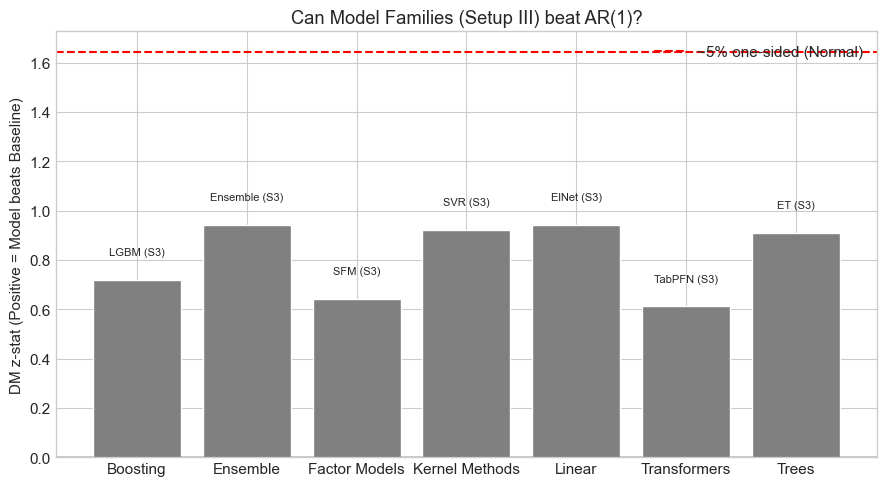

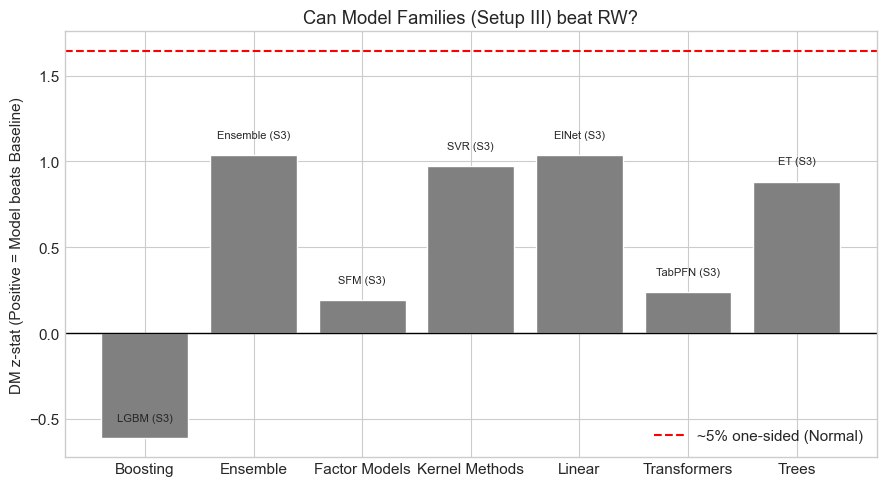

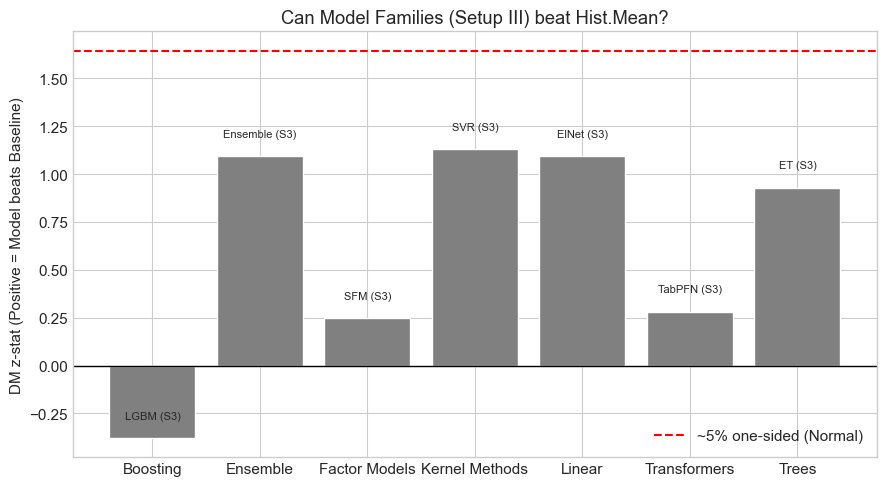

In [16]:

# =============================================================================
# Baseline vs Family (best model per family in Setup III) - DM bars
# FIX: DM one-sided HAC normal; computed on intersection (baseline, model, y_true)
# =============================================================================

if baseline_keys and s3_keys:
    families_s3 = sorted(
        list(set(MODEL_MAPPING["Setup_3"][k]["family"] for k in s3_keys if k in MODEL_MAPPING["Setup_3"])))

    for bl_key in baseline_keys:
        plot_data = []

        for fam in families_s3:
            fam_models = [k for k in s3_keys if MODEL_MAPPING["Setup_3"][k]["family"] == fam]
            if not fam_models:
                continue

            # Choose best family model using pairwise RMSE (descriptive), but DM computed on intersection with baseline
            # (You can also choose best-on-common-with-baseline if you want to be ultra strict.)
            best_fam_model = min(fam_models,
                                 key=lambda m: rmse_on_df(get_common_df(df_full, [m, "y_true"]), m) if get_common_df(
                                     df_full, [m, "y_true"]) is not None else np.inf)

            tmp = get_common_df(df_full, [best_fam_model, bl_key, "y_true"])
            if tmp is None or len(tmp) < 15:
                continue

            e_bl = tmp["y_true"] - tmp[bl_key]
            e_mod = tmp["y_true"] - tmp[best_fam_model]
            t_stat, p_val = calculate_dm_test_onesided(e_bl, e_mod, h=12)

            plot_data.append({"Family": fam, "BestModel": best_fam_model, "t-stat": t_stat, "p-val": p_val})

        if plot_data:
            df_p = pd.DataFrame(plot_data)
            plt.figure(figsize=(9, 5))
            colors = ["#2ca02c" if (r["t-stat"] > 0 and r["p-val"] < 0.10) else "grey" for _, r in df_p.iterrows()]
            bars = plt.bar(df_p["Family"], df_p["t-stat"], color=colors)
            plt.axhline(0, color="black", lw=1)
            plt.axhline(1.6449, color="red", linestyle="--", label="~5% one-sided (Normal)")

            for bar, name in zip(bars, df_p["BestModel"]):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, name, ha='center', fontsize=8)

            plt.title(f"Can Model Families (Setup III) beat {bl_key}?")
            plt.ylabel("DM z-stat (Positive = Model beats Baseline)")
            plt.legend()
            plt.tight_layout()
            plt.show()


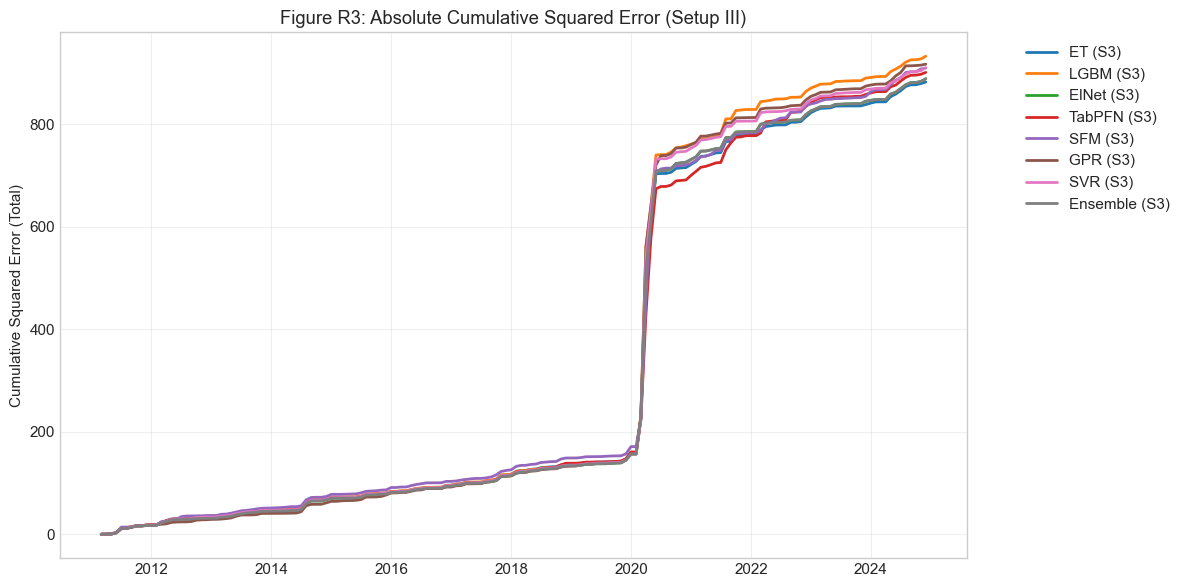


=== ROBUSTNESS (Exogenous Trim) ===
Original N: 166 | Trimmed N: 156 | Dropped: 10

>>> TABLE R1 (Strict Common): Setup I (Robust) <<<
Evaluated on N=156 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,ET (S1),1.583016,1.154844,YES
1,LGBM (S1),1.649579,1.209988,YES
2,ElNet (S1),1.535773,1.227792,YES
3,TabPFN (S1),1.543124,1.142711,YES
4,SFM (S1),1.651021,1.288244,no
5,GPR (S1),1.704497,1.241497,no
6,SVR (S1),1.575921,1.146012,YES
7,Ensemble (S1),1.511907,1.178324,YES



>>> TABLE R1 (Strict Common): Setup II (Robust) <<<
Evaluated on N=156 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,ET (S2),0.999134,0.713292,YES
1,LGBM (S2),0.984071,0.655993,YES
2,ElNet (S2),1.292171,1.002700,no
3,TabPFN (S2),1.394960,1.028855,no
4,SFM (S2),1.941305,1.469718,no
5,GPR (S2),1.956652,1.303771,no
6,SVR (S2),1.781948,1.359837,no
7,Ensemble (S2),0.939034,0.622879,YES



>>> TABLE R1 (Strict Common): Setup III (Robust) <<<
Evaluated on N=156 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,ET (S3),1.560521,1.131094,YES
1,LGBM (S3),1.582541,1.135223,YES
2,ElNet (S3),1.563337,1.119956,YES
3,TabPFN (S3),1.644969,1.190693,YES
4,SFM (S3),1.589061,1.194830,YES
5,GPR (S3),1.527287,1.110106,YES
6,SVR (S3),1.567664,1.127720,YES
7,Ensemble (S3),1.563337,1.119956,YES


(                ET (S3)  LGBM (S3)  ElNet (S3)  TabPFN (S3)  SFM (S3)  \
 date_t_plus_1                                                           
 2011-04-01     0.332354  -0.054402    0.201930     0.351902  0.159534   
 2011-05-01     0.320623  -0.084256    0.251719     0.559716 -0.323059   
 2011-06-01     0.217585  -0.040662    0.085012     0.321768 -0.220667   
 2011-07-01     0.089889  -0.021055    0.095224     0.183058 -0.326584   
 2011-08-01     0.127293  -0.034252   -0.090865    -0.075923 -0.346137   
 ...                 ...        ...         ...          ...       ...   
 2024-08-01    -0.207166  -0.198469   -0.087389    -0.046812 -0.524728   
 2024-09-01    -0.322750  -0.078056   -0.059416    -0.113020 -0.989555   
 2024-10-01    -0.223386   0.223764   -0.070539     0.015786 -0.435095   
 2024-11-01    -0.209792   0.164937   -0.071345     0.032405 -1.018342   
 2024-12-01    -0.642096  -0.068533   -0.079932    -0.463857 -1.009910   
 
                GPR (S3)  SVR (S3)  

In [20]:


# =============================================================================
# Robustness
# Figure R3 (CSED style / CSE): Cumulative squared errors (Setup III)
# =============================================================================

if s3_keys:
    plt.figure(figsize=(12, 6))
    for k in s3_keys:
        temp = df_full[[k, "y_true"]].dropna()
        if temp.empty:
            continue
        cse_mod = ((temp["y_true"] - temp[k]) ** 2).cumsum()
        plt.plot(cse_mod.index, cse_mod, label=k, linewidth=2)
    plt.title("Figure R3: Absolute Cumulative Squared Error (Setup III)")
    plt.ylabel("Cumulative Squared Error (Total)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =============================================================================
# ROBUSTNESS: Exogenous trimming (top 5% target volatility removed) + evaluation
# =============================================================================

y = df_full["y_true"]
y_volatility = y.diff().abs()
threshold = y_volatility.quantile(0.95)
mask_keep = y_volatility <= threshold
df_robust = df_full.loc[mask_keep].copy()

print(f"\n=== ROBUSTNESS (Exogenous Trim) ===")
print(f"Original N: {len(df_full)} | Trimmed N: {len(df_robust)} | Dropped: {len(df_full) - len(df_robust)}")

evaluate_setup_strict("Setup I (Robust)", MODEL_MAPPING["Setup_1"], df_robust)
evaluate_setup_strict("Setup II (Robust)", MODEL_MAPPING["Setup_2"], df_robust)
evaluate_setup_strict("Setup III (Robust)", MODEL_MAPPING["Setup_3"], df_robust)


Diagnostics for: ['RW', 'TabPFN (S1)', 'Ensemble (S2)', 'ET (S3)']

>>> Ljung-Box Test (Lags=10) <<<


,Model,Type,Q-Stat,p-value,Conclusion
0,RW,Baseline (Best),26.77,0.0028,Autocorrelated (Bad)
1,TabPFN (S1),Setup I (Best),29.04,0.0012,Autocorrelated (Bad)
2,Ensemble (S2),Setup II (Best),29.02,0.0012,Autocorrelated (Bad)
3,ET (S3),Setup III (Best),29.96,0.0009,Autocorrelated (Bad)


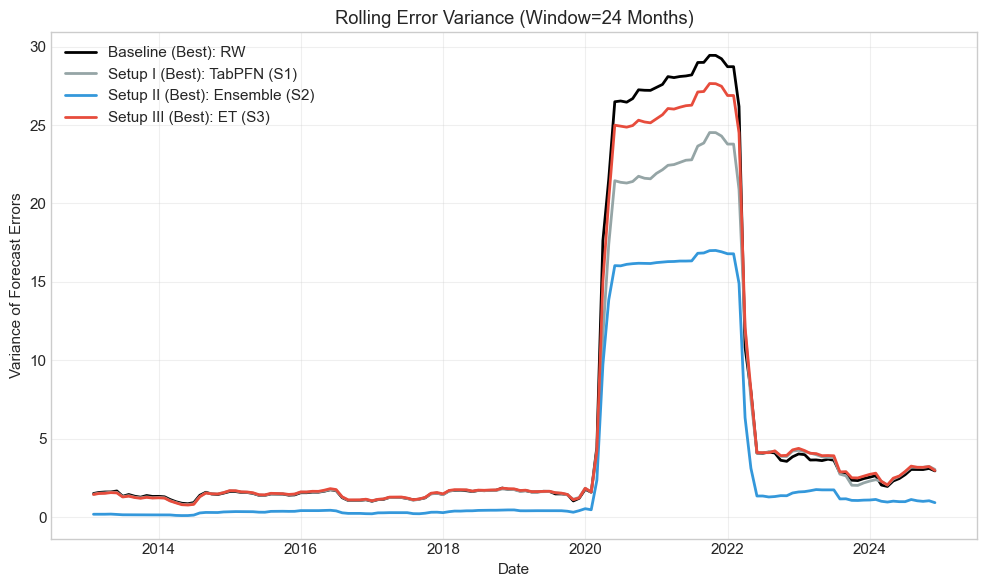

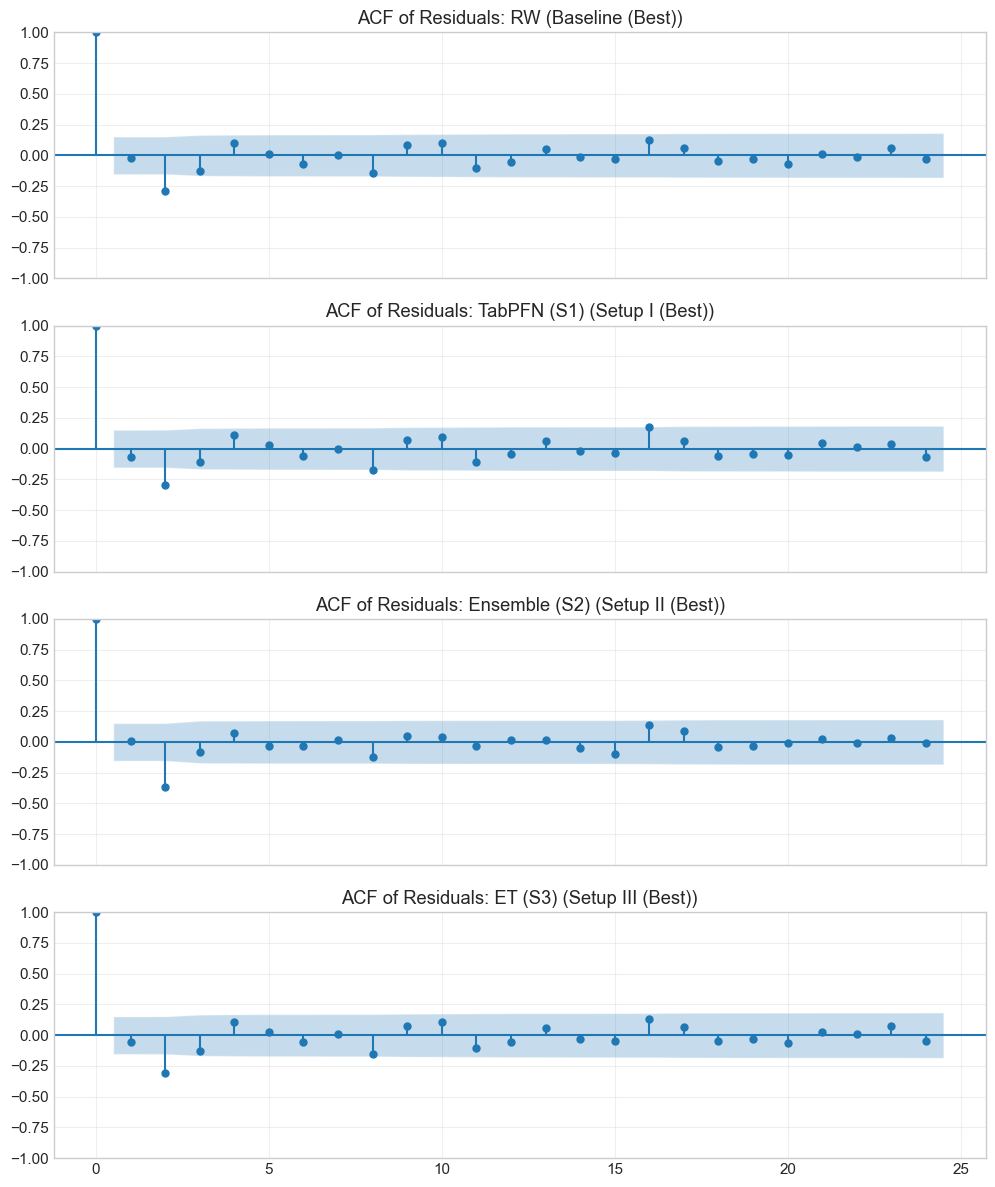

In [17]:

# =============================================================================
# Diagnostics: Ljung-Box, Rolling Variance, ACF for selected models
# =============================================================================

def get_best_model_name_on_common(setup_key: str, df: pd.DataFrame):
    if setup_key not in MODEL_MAPPING:
        return None
    models = [m for m in MODEL_MAPPING[setup_key].keys() if m in df.columns]
    if not models:
        return None
    tmp = get_common_df(df, models + ["y_true"])
    if tmp is None or len(tmp) < 15:
        # fallback: choose best pairwise (descriptive)
        rmse_map = {}
        for m in models:
            t = get_common_df(df, [m, "y_true"])
            rmse_map[m] = rmse_on_df(t, m) if t is not None else np.inf
        return min(rmse_map, key=rmse_map.get)
    best, _ = best_model_on_common(tmp, models)
    return best


selected_models = []

# Best baseline (pairwise) for diagnostics
if baseline_keys:
    best_bl = best_baseline_name(df_full, baseline_keys)
    if best_bl is not None:
        selected_models.append((best_bl, "Baseline (Best)", "black"))

setup_colors = {"Setup_1": "#95a5a6", "Setup_2": "#3498db", "Setup_3": "#e74c3c"}
setup_labels = {"Setup_1": "Setup I (Best)", "Setup_2": "Setup II (Best)", "Setup_3": "Setup III (Best)"}

for s_key, col in setup_colors.items():
    best_mod = get_best_model_name_on_common(s_key, df_full)
    if best_mod:
        selected_models.append((best_mod, setup_labels[s_key], col))

print("Diagnostics for:", [m[0] for m in selected_models])

# Ljung-Box table
lb_results = []
lags_to_test = 10

for name, label, _ in selected_models:
    resid = (df_full["y_true"] - df_full[name]).dropna()
    if len(resid) < lags_to_test + 5:
        continue

    lb = acorr_ljungbox(resid, lags=[lags_to_test], return_df=True)
    stat = float(lb.iloc[0]["lb_stat"])
    pval = float(lb.iloc[0]["lb_pvalue"])
    lb_results.append({
        "Model": name,
        "Type": label,
        "Q-Stat": stat,
        "p-value": pval,
        "Conclusion": "White Noise (Good)" if pval > 0.05 else "Autocorrelated (Bad)"
    })

df_lb = pd.DataFrame(lb_results)
if not df_lb.empty:
    print(f"\n>>> Ljung-Box Test (Lags={lags_to_test}) <<<")
    display(df_lb.style.format({"Q-Stat": "{:.2f}", "p-value": "{:.4f}"})
            .background_gradient(subset=["p-value"], cmap="RdYlGn", vmin=0, vmax=0.1))

# Rolling error variance
window_size = 24
plt.figure(figsize=(10, 6))
for name, label, col in selected_models:
    resid = (df_full["y_true"] - df_full[name]).dropna()
    if len(resid) < window_size + 5:
        continue
    roll_var = resid.rolling(window=window_size).var()
    plt.plot(roll_var.index, roll_var, label=f"{label}: {name}", color=col, linewidth=2)

plt.title(f"Rolling Error Variance (Window={window_size} Months)")
plt.ylabel("Variance of Forecast Errors")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ACF plots
if selected_models:
    fig, axes = plt.subplots(len(selected_models), 1, figsize=(10, 3 * len(selected_models)), sharex=True)
    if len(selected_models) == 1:
        axes = [axes]

    for ax, (name, label, col) in zip(axes, selected_models):
        resid = (df_full["y_true"] - df_full[name]).dropna()
        if len(resid) < 30:
            ax.set_title(f"ACF skipped (too short): {name}")
            continue
        plot_acf(resid, lags=24, ax=ax, title=f"ACF of Residuals: {name} ({label})")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Lade Feature Daten: raw_importance_MEAN_full_run.csv
Grafiken werden gespeichert in: /Users/jonasschernich/Documents/Masterarbeit/Code/grafiken
Zeitachse erfolgreich wiederhergestellt.


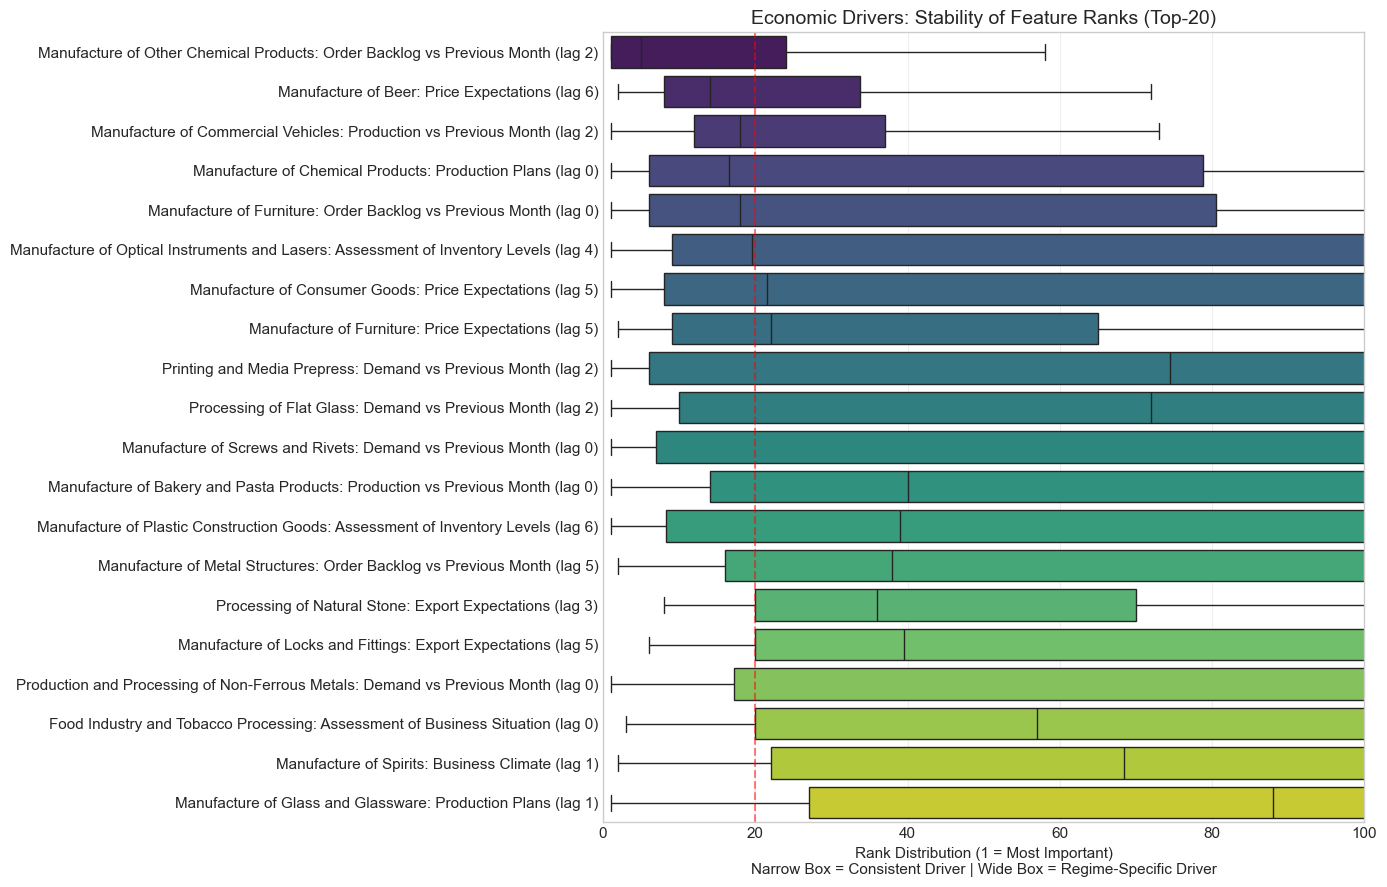

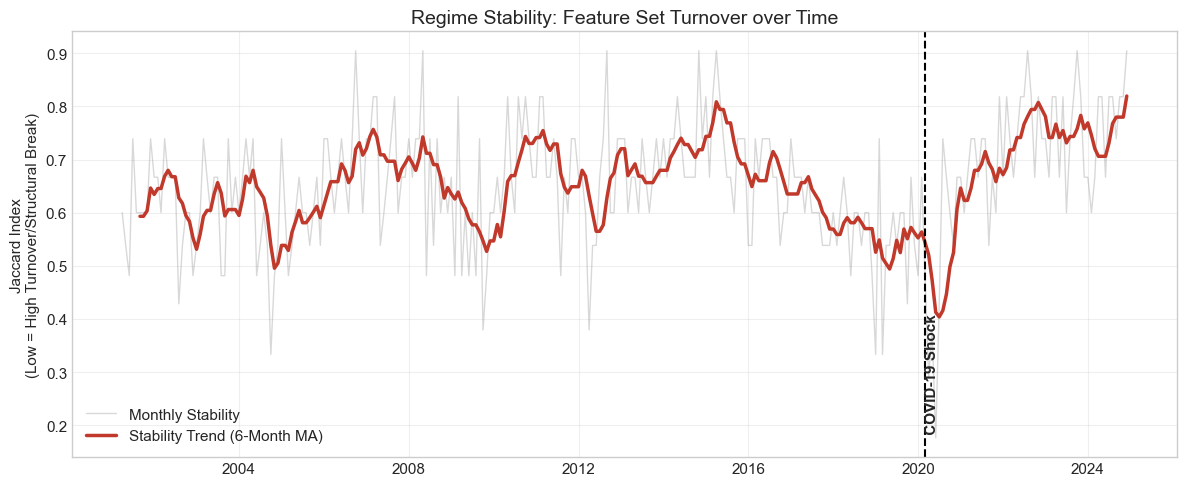

/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_58719/163812770.py:237: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(graphics_dir / "Feature_Concentration_Curve.png", dpi=300, bbox_inches="tight")
/Users/jonasschernich/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


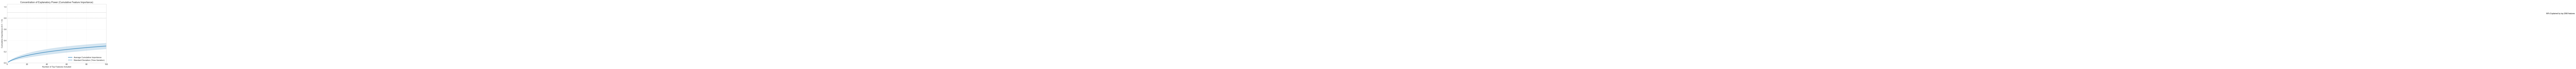

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

# =============================================================================
# Helper: Feature Name Translation (German -> English, Full Names)
# =============================================================================

SECTOR_MAP_OPT = {
    # Chemie & Pharma
    "Herstellung_von_sonstigen_chemischen_Erzeugnissen": "Manufacture of Other Chemical Products n.e.c.",
    "Herstellung_von_chemischen_Erzeugnissen": "Manufacture of Chemicals and Chemical Products",
    "Herstellung_von_Baubedarfsartikeln_aus_Kunststoffen": "Manufacture of Plastic Products for Construction",

    # Lebensmittel & Genuss
    "Herstellung_von_Bier": "Manufacture of Beer",
    "Herstellung_von_Back__und_Teigwaren": "Manufacture of Bakery and Pasta Products",
    "Ern_hrungsgewerbe_und_Tabakverarbeitung": "Manufacture of Food Products and Tobacco Products",
    "Herstellung_von_Spirituosen": "Manufacture of Spirits",

    # Fahrzeuge
    "Herstellung_von_Nutzkraftwagen": "Manufacture of Commercial Vehicles",
    "Herstellung_von_Kraftwagen_und_Kraftwagenteilen": "Manufacture of Motor Vehicles and Parts",

    # Metall & Maschinen
    "Herstellung_von_Schrauben_und_Nieten": "Manufacture of Fasteners (Screws and Rivets)",
    "Herstellung_von_Metallkonstruktionen": "Manufacture of Metal Structures",
    "Herstellung_von_Schl_ssern_und_Beschl_gen": "Manufacture of Locks and Fittings",
    "Erzeugung_und_erste_Bearbeitung_von_NE_Metallen": "Production and Primary Processing of Non-Ferrous Metals",
    "Maschinenbau": "Manufacture of Machinery and Equipment",

    # Glas, Keramik, Steine
    "Veredelung_und_Bearbeitung_von_Flachglas": "Processing and Finishing of Flat Glass",
    "Be__und_Verarbeitung_von_Naturwerk__und_Natursteinen": "Processing of Natural Stone and Related Products",
    "Herstellung_von_Glas_und_Glaswaren": "Manufacture of Glass and Glassware",

    # Sonstige
    "Herstellung_von_M_beln": "Manufacture of Furniture",
    "Herstellung_von_optischen_Instrumenten_und_Lasern": "Manufacture of Optical Instruments and Lasers",
    "Herstellung_von_Gebrauchsg_tern": "Manufacture of Miscellaneous Consumer Goods",
    "Druck_und_Medienvorstufe": "Printing and Prepress Services",
}

INDICATOR_MAP_OPT = {
    "Auftragsbestand_gegen_Vormonat": "Order Book (m/m)",
    "Preiserwartungen": "Price Expectations",
    "Produktion_gegen_Vormonat": "Production (m/m)",
    "Produktionspl_ne": "Production Plans",
    "Fertigwarenlager_Beurteilung": "Assessment of Finished Goods Inventories",
    "Nachfrage_gegen_Vormonat": "Demand (m/m)",
    "Gesch_ftslage_Beurteilung": "Assessment of Current Business Situation",
    "Gesch_ftsklima": "Business Climate",
    "Exporterwartungen": "Export Expectations",
    "Besch_ftigungserwartungen": "Employment Expectations",
}

def translate_feature_label(raw_label):
    """
    Zerlegt: Sektor.Indikator__lagX
    Übersetzt Teile und baut zusammen: Sector: Indicator (lag X)
    """
    # 1. Lag extrahieren
    if "__lag" in raw_label:
        base, lag_part = raw_label.split("__lag")
        lag_str = f" (lag {lag_part})"
    else:
        base = raw_label
        lag_str = ""

    # 2. Sektor und Indikator trennen
    if "." in base:
        parts = base.split(".")
        sector_raw = parts[0]
        indicator_raw = ".".join(parts[1:])
    else:
        sector_raw = base
        indicator_raw = ""

    # 3. Übersetzen (Fallback auf Original, falls nicht im Dict)
    sec_en = SECTOR_MAP.get(sector_raw, sector_raw)
    ind_en = INDICATOR_MAP.get(indicator_raw, indicator_raw)

    # 4. Zusammenbauen
    if ind_en:
        return f"{sec_en}: {ind_en}{lag_str}"
    else:
        return f"{sec_en}{lag_str}"

# =============================================================================
# Feature Importance Logic & Plots
# =============================================================================

path_imp = PROJECT_ROOT / "outputs" / "feature_importance" / "outputs_no_missing" / "raw_importance_MEAN_full_run.csv"

if path_imp.exists():
    print(f"Lade Feature Daten: {path_imp.name}")
    df_imp = pd.read_csv(path_imp, index_col=0)

    # --- NEU: Output-Verzeichnis für Grafiken erstellen ---
    graphics_dir = PROJECT_ROOT / "grafiken"
    graphics_dir.mkdir(parents=True, exist_ok=True)
    print(f"Grafiken werden gespeichert in: {graphics_dir}")

    # Restore date index if possible
    try:
        from src.io_timesplits import load_target
        y_full = load_target()
        START_ORIGIN = 120
        start_idx = START_ORIGIN + 1
        end_idx = start_idx + len(df_imp)
        if end_idx <= len(y_full):
            df_imp.index = y_full.index[start_idx:end_idx]
            print("Zeitachse erfolgreich wiederhergestellt.")
    except Exception as e:
        print(f"Zeitachsen-Fix übersprungen ({e}).")

    # -------------------------------------------------------------------------
    # PLOT 1: Rank stability (Boxplot) with Translations
    # -------------------------------------------------------------------------
    df_ranks = df_imp.rank(axis=1, ascending=False, method='min')
    is_top20 = (df_ranks <= 20)

    # Die Top 20 Features (basierend auf Durchschnitts-Rank)
    top_20_feats = is_top20.mean().sort_values(ascending=False).head(20).index.tolist()

    df_box = df_ranks[top_20_feats].melt(var_name="Feature", value_name="Rank")

    # --- Übersetzung anwenden ---
    df_box["Feature_Label"] = df_box["Feature"].apply(translate_feature_label)

    # Sortierreihenfolge für den Plot bestimmen
    order_labels = [translate_feature_label(f) for f in top_20_feats]

    plt.figure(figsize=(14, 9))
    sns.boxplot(data=df_box, x="Rank", y="Feature_Label", palette="viridis",
                showfliers=False, hue="Feature_Label", legend=False,
                order=order_labels)

    plt.title("Economic Drivers: Stability of Feature Ranks (Top-20)", fontsize=14)
    plt.xlabel(
        "Rank Distribution (1 = Most Important)\nNarrow Box = Consistent Driver | Wide Box = Regime-Specific Driver",
        fontsize=11)
    plt.ylabel("")
    plt.axvline(20, color='red', linestyle='--', alpha=0.5)
    plt.grid(True, axis='x', alpha=0.3)
    plt.xlim(0, 100)
    plt.tight_layout()

    # --- SPEICHERN ---
    plt.savefig(graphics_dir / "Feature_Rank_Stability_Top20.png", dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------------------------------------------------------
    # PLOT 2: Jaccard turnover (structural breaks)
    # -------------------------------------------------------------------------
    jaccard_indices = []
    dates = df_ranks.index
    K = 20

    for i in range(1, len(dates)):
        set_t = set(df_ranks.iloc[i].nsmallest(K).index)
        set_prev = set(df_ranks.iloc[i - 1].nsmallest(K).index)
        union = len(set_t.union(set_prev))
        j = len(set_t.intersection(set_prev)) / union if union > 0 else 0
        jaccard_indices.append({"Date": dates[i], "Jaccard": j})

    df_jacc = pd.DataFrame(jaccard_indices).set_index("Date")

    plt.figure(figsize=(12, 5))
    plt.plot(df_jacc.index, df_jacc["Jaccard"], color="gray", alpha=0.3, linewidth=1, label="Monthly Stability")
    window = 6
    plt.plot(df_jacc.index, df_jacc["Jaccard"].rolling(window).mean(),
             color="#c0392b", linewidth=2.5, label=f"Stability Trend ({window}-Month MA)")

    plt.title("Regime Stability: Feature Set Turnover over Time", fontsize=14)
    plt.ylabel("Jaccard Index\n(Low = High Turnover/Structural Break)", fontsize=11)

    try:
        corona = pd.Timestamp("2020-03-01")
        if isinstance(df_jacc.index, pd.DatetimeIndex) and df_jacc.index.min() < corona < df_jacc.index.max():
            plt.axvline(corona, color='black', linestyle='--', linewidth=1.5)
            plt.text(corona, df_jacc["Jaccard"].min(), " COVID-19 Shock", rotation=90, va='bottom', fontweight='bold')
    except:
        pass

    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # --- SPEICHERN ---
    plt.savefig(graphics_dir / "Feature_Jaccard_Stability.png", dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------------------------------------------------------
    # PLOT 3: Concentration (cumulative importance)
    # -------------------------------------------------------------------------
    df_norm = df_imp.div(df_imp.sum(axis=1), axis=0)
    cumulative_curves = []
    for _, row in df_norm.iterrows():
        sorted_vals = row.sort_values(ascending=False).values
        cumulative_curves.append(np.cumsum(sorted_vals))

    df_cum = pd.DataFrame(cumulative_curves)
    mean_curve = df_cum.mean(axis=0)
    std_curve = df_cum.std(axis=0)
    x_axis = np.arange(1, len(mean_curve) + 1)

    plt.figure(figsize=(10, 6), layout='constrained')

    plt.plot(x_axis, mean_curve, color="#2980b9", linewidth=2.5, label="Average Cumulative Importance")
    plt.fill_between(x_axis, mean_curve - std_curve, mean_curve + std_curve,
                     color="#2980b9", alpha=0.2, label="Standard Deviation (Time-Variation)")

    plt.axhline(0.8, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(0.9, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    try:
        idx_90 = np.where(mean_curve >= 0.9)[0][0]
        feat_90 = x_axis[idx_90]
        plt.plot(feat_90, mean_curve[idx_90], 'ro')
        plt.text(feat_90 + 2, 0.88, f"90% Explained by top {feat_90} features",
                 color='black', fontsize=10, va='center')
    except:
        pass

    plt.title("Concentration of Explanatory Power (Cumulative Feature Importance)")
    plt.xlabel("Number of Top Features Included")
    plt.ylabel("Cumulative Importance (0.0 - 1.0)")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 100)
    plt.ylim(0, 1.05)

    # --- SPEICHERN ---
    plt.savefig(graphics_dir / "Feature_Concentration_Curve.png", dpi=300, bbox_inches="tight")
    plt.show()

else:
    print(f"Feature importance file not found: {path_imp}")

Konsens Top 20 bestimmt (Platz 1: Herstellung_von_sonstigen_chemischen_Erzeugnissen.Auftragsbestand_gegen_Vormonat__lag2)

=== Wieviel % der Modell-Power liegt in den Konsens-Top-20? ===
       Share_of_Consensus_Top20 (%)
Model                              
EN                             1.15
ET                             3.38
LGBM                          19.15


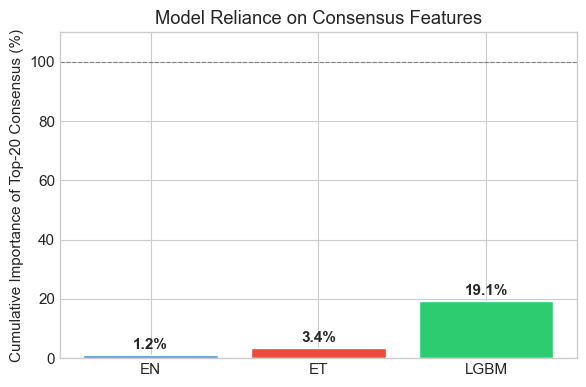

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pfad Setup (Analog zu deinem Skript)
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "feature_importance" / "outputs_no_missing"
run_name = "full_run"

# 1. Die "Konsens"-Liste bestimmen (Top 20 aus dem MEAN)
path_mean = OUTPUT_DIR / f"raw_importance_MEAN_{run_name}.csv"
if not path_mean.exists():
    raise FileNotFoundError("Bitte erst den Mean-Importance Job laufen lassen!")

df_mean = pd.read_csv(path_mean, index_col=0)
# Sicherstellen, dass alles sum=1 ist (zur Sicherheit)
df_mean_norm = df_mean.div(df_mean.sum(axis=1), axis=0)

# Die Top 20 Features basierend auf dem Durchschnitt über die Zeit
top_20_consensus = df_mean_norm.mean().sort_values(ascending=False).head(20).index.tolist()

print(f"Konsens Top 20 bestimmt (Platz 1: {top_20_consensus[0]})")

# 2. Loop über die Einzelmodelle
models = ["EN", "ET", "LGBM"]
results = []

for m in models:
    path_model = OUTPUT_DIR / f"raw_importance_{m}_{run_name}.csv"

    if path_model.exists():
        # Laden
        df_m = pd.read_csv(path_model, index_col=0)

        # WICHTIG: Normalisieren auf 1.0 (100%), damit Prozentwerte stimmen
        # ElasticNet hat z.B. Summen von >100 oder <1 bei Koeffizienten, LGBM hat riesige Gain-Werte
        df_m_norm = df_m.div(df_m.sum(axis=1), axis=0).fillna(0.0)

        # Filtern: Nur die Spalten, die im "Konsens Top 20" sind
        # (reindex füllt fehlende Features mit 0 auf, falls ein Modell ein Feature nie gewählt hat)
        df_top20_only = df_m_norm.reindex(columns=top_20_consensus, fill_value=0.0)

        # Summe bilden: Wieviel % machen diese 20 Features in diesem Modell aus?
        # Wir berechnen den Durchschnitt über die Zeit
        avg_share = df_top20_only.sum(axis=1).mean() * 100

        results.append({
            "Model": m,
            "Share_of_Consensus_Top20 (%)": avg_share
        })
    else:
        print(f"Warnung: Datei für {m} nicht gefunden.")

# 3. Ergebnis Tabelle
df_res = pd.DataFrame(results).set_index("Model")
print("\n=== Wieviel % der Modell-Power liegt in den Konsens-Top-20? ===")
print(df_res.round(2))

# 4. Optional: Visualisierung
plt.figure(figsize=(6, 4))
bars = plt.bar(df_res.index, df_res["Share_of_Consensus_Top20 (%)"], color=['#3498db', '#e74c3c', '#2ecc71'])
plt.axhline(100, color='gray', linestyle='--', linewidth=0.8)
plt.ylabel("Cumulative Importance of Top-20 Consensus (%)")
plt.title("Model Reliance on Consensus Features")
plt.ylim(0, 110)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [69]:
import pandas as pd
import numpy as np

# Setup Pfade
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "feature_importance" / "outputs_no_missing"
run_name = "full_run"
models = ["EN", "ET", "LGBM", "MEAN"]
thresholds = [0.50, 0.95, 0.99]

results_concentration = []

print(f"Analysiere Feature-Konzentration für: {models}\n")

for m in models:
    # 1. Datei laden
    path_model = OUTPUT_DIR / f"raw_importance_{m}_{run_name}.csv"

    if path_model.exists():
        df = pd.read_csv(path_model, index_col=0)

        # 2. Normalisieren (Zeilensumme = 1.0)
        # Wichtig: Zuerst negative Werte (falls bei EN vorhanden) in Betrag wandeln?
        # EN coefs sind meist schon abs() im vorherigen Step, aber sicher ist sicher:
        df = df.abs()
        df_norm = df.div(df.sum(axis=1), axis=0).fillna(0.0)

        # 3. Durchschnitt über die Zeit bilden -> Globales Ranking
        mean_importance = df_norm.mean().sort_values(ascending=False)

        # 4. Kumulative Summe
        cum_curve = mean_importance.cumsum()

        # Gesamtanzahl Features in diesem Modell
        total_feats = len(cum_curve)

        # 5. Schwellenwerte berechnen
        row = {"Model": m, "Total Features": total_feats}

        for t in thresholds:
            # np.argmax findet den ersten Index, wo die Bedingung True ist
            # Da Python 0-indiziert ist, müssen wir +1 rechnen für die "Anzahl"
            # Beispiel: Wenn Index 0 schon > 0.5 ist, brauchen wir 1 Feature.

            # Schutzmechanismus, falls 99% nie erreicht wird (wegen Rundung)
            if cum_curve.max() < t:
                n_needed = total_feats
            else:
                n_needed = np.argmax(cum_curve.values >= t) + 1

            pct_needed = (n_needed / total_feats) * 100

            # Format: "Anzahl (Prozent%)"
            row[f"{int(t*100)}% Expl."] = f"{n_needed} ({pct_needed:.1f}%)"

        results_concentration.append(row)
    else:
        print(f"Warnung: Datei für {m} nicht gefunden.")

# Tabelle erstellen
df_conc = pd.DataFrame(results_concentration).set_index("Model")

print("=== FEATURE CONCENTRATION ANALYSIS ===")
print("Wie viele Features sind nötig, um X% der Modell-Information zu erklären?")
print("-" * 80)
print(df_conc.to_string())
print("-" * 80)

# Optional: Als CSV für LaTeX Export speichern
# df_conc.to_csv("table_feature_concentration.csv")

Analysiere Feature-Konzentration für: ['EN', 'ET', 'LGBM', 'MEAN']

=== FEATURE CONCENTRATION ANALYSIS ===
Wie viele Features sind nötig, um X% der Modell-Information zu erklären?
--------------------------------------------------------------------------------
       Total Features     50% Expl.     95% Expl.     99% Expl.
Model                                                          
EN               4320  1049 (24.3%)  3576 (82.8%)  4100 (94.9%)
ET               4320   706 (16.3%)  3499 (81.0%)  4082 (94.5%)
LGBM             4320    118 (2.7%)  1305 (30.2%)  2268 (52.5%)
MEAN             4320   643 (14.9%)  3473 (80.4%)  4079 (94.4%)
--------------------------------------------------------------------------------


In [74]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# =============================================================================
# DM-Test: GPR (Setup 3) vs. Running Mean
# =============================================================================

# Konfiguration
model_col = "GPR (S3)"       # Name in deinem DataFrame
bench_col = "Running Mean"   # Name der Baseline
target_col = "y_true"

# 1. Gemeinsame Datenbasis filtern
df_test = df_full[[model_col, bench_col, target_col]].dropna()

if len(df_test) > 15:
    # 2. Fehler berechnen
    e_bench = df_test[target_col] - df_test[bench_col]
    e_model = df_test[target_col] - df_test[model_col]

    # 3. Differenz der quadrierten Fehler (d = e_bench^2 - e_model^2)
    # d > 0 bedeutet: Benchmark-Fehler ist größer -> Modell ist besser
    d = (e_bench**2) - (e_model**2)

    # 4. DM-Test (HAC-Standardfehler)
    T = len(d)
    lags = int(T**(0.25))
    res = sm.OLS(d, np.ones(T)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    t_stat = res.tvalues[0]
    p_val_two_sided = res.pvalues[0]

    # Interpretation
    rmse_model = np.sqrt(np.mean(e_model**2))
    rmse_bench = np.sqrt(np.mean(e_bench**2))
    ratio = rmse_model / rmse_bench

    is_sig_5 = p_val_two_sided < 0.05
    is_better = (t_stat > 0) and is_sig_5  # t > 0 heißt Model error < Bench error

    print(f"--- DM Test: {model_col} vs {bench_col} ---")
    print(f"n           : {T}")
    print(f"RMSE Model  : {rmse_model:.4f}")
    print(f"RMSE Bench  : {rmse_bench:.4f}")
    print(f"Ratio       : {ratio:.4f}")
    print(f"t-statistic : {t_stat:.4f}")
    print(f"p-value (2s): {p_val_two_sided:.4f}")

    if is_better:
        print("RESULT: GPR (S3) is SIGNIFICANTLY BETTER (p < 0.05).")
    elif is_sig_5 and t_stat < 0:
        print("RESULT: GPR (S3) is SIGNIFICANTLY WORSE (p < 0.05).")
    else:
        print("RESULT: No significant difference.")
else:
    print("Nicht genügend Daten für den Test.")

--- DM Test: GPR (S3) vs Running Mean ---
n           : 166
RMSE Model  : 2.3508
RMSE Bench  : 2.3772
Ratio       : 0.9889
t-statistic : 0.9040
p-value (2s): 0.3660
RESULT: No significant difference.


In [77]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# =============================================================================
# 1. DATEN LADEN: Elastic Net 7000
# =============================================================================

# Pfad zur neuen Vorhersage (basierend auf deinem Screenshot/Pfad-Struktur)
path_7000 = PROJECT_ROOT / "outputs" / "stageB" / "elastic_net_with_targetfeatures_7000" / "monthly"/"preds.csv"
col_7000 = "Elastic Net (7000)"
col_700 = "Elastic Net (S2)"  # Das existierende 700er Modell

if path_7000.exists():
    print(f"Lade Vorhersagen von: {path_7000.name}")
    # CSV laden, Index als Datum parsen
    df_new = pd.read_csv(path_7000, index_col=0, parse_dates=True)

    # Wir nehmen an, die Vorhersage steht in der ersten Spalte (meist "mean" oder "prediction")
    # Wir benennen sie um und fügen sie df_full hinzu
    s_new = df_new.iloc[:, 0].rename(col_7000)

    # In df_full integrieren (join updated existierende Indizes)
    # Wir nutzen combine_first, um nichts zu überschreiben, falls es schon da wäre,
    # oder merge/join. Hier einfach Zuweisung über Index-Matching:
    df_full[col_7000] = s_new

    print(f"Erfolgreich geladen. Spalte '{col_7000}' zu df_full hinzugefügt.")
else:
    print(f"FEHLER: Datei nicht gefunden unter {path_7000}")

# =============================================================================
# 2. DM-TEST: 700 vs. 7000 Features
# =============================================================================

if col_700 in df_full.columns and col_7000 in df_full.columns:
    target_col = "y_true"

    # Gemeinsame Datenbasis filtern
    df_test = df_full[[col_7000, col_700, target_col]].dropna()

    if len(df_test) > 15:
        # Fehler berechnen
        e_bench = df_test[target_col] - df_test[col_700]   # 700 Features (Benchmark)
        e_chall = df_test[target_col] - df_test[col_7000]  # 7000 Features (Challenger)

        # DM-Statistik (Differenz der quadrierten Fehler)
        # d > 0  => e_bench^2 > e_chall^2 => Challenger (7000) ist besser
        d = (e_bench**2) - (e_chall**2)

        T = len(d)
        lags = int(T**(0.25))
        res = sm.OLS(d, np.ones(T)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

        t_stat = res.tvalues[0]
        p_val = res.pvalues[0]

        rmse_bench = np.sqrt(np.mean(e_bench**2))
        rmse_chall = np.sqrt(np.mean(e_chall**2))
        ratio = rmse_chall / rmse_bench

        print(f"\n>>> RESULT: Elastic Net 700 vs. 7000 Features <<<")
        print(f"n           : {T}")
        print(f"RMSE (700)  : {rmse_bench:.4f}")
        print(f"RMSE (7000) : {rmse_chall:.4f}")
        print(f"Ratio       : {ratio:.4f}")
        print(f"t-statistic : {t_stat:.4f}")
        print(f"p-value     : {p_val:.4f}")

        if p_val < 0.05:
            if t_stat > 0:
                print("-> 7000 Features sind SIGNIFIKANT BESSER.")
            else:
                print("-> 7000 Features sind SIGNIFIKANT SCHLECHTER (Overfitting).")
        else:
            print("-> Kein signifikanter Unterschied.")
            if ratio < 1.0:
                print("   (Tendenz: 7000 ist minimal besser, aber statistisch insignifikant)")
            else:
                print("   (Tendenz: 7000 ist minimal schlechter/gleich)")
    else:
        print("Zu wenige gemeinsame Datenpunkte.")
else:
    print("Konnte Test nicht durchführen, Spalten fehlen.")

Lade Vorhersagen von: preds.csv


/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_58719/3141194785.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_new = pd.read_csv(path_7000, index_col=0, parse_dates=True)


ValueError: cannot reindex on an axis with duplicate labels